source("~/setup/setup.R")

# this file has a bunch of patents issued

# R code which
* generates the patent links
* calculates the peer returns

In [ ]:
source("~/setup/setup.R")


if(0)tableDropClickhousePublic('class.techlinks') # this function drops a table
for(n in c(5,10))
for(this.year in seq(1966,2019)){

print(paste(this.year,Sys.time()))  
# add 60 to each date b/c we want to minimize look-ahead bias
      # we assume that 
start=paste(this.year-n,'01','01',sep='-')
end=paste(this.year-1,'12','31',sep='-')

if(this.year>='2011'){


  dta=queryClickhouseDbPublic("select toInt32(permno) as permno,
      mainclass_id as class,{this.year} as year,
               toInt32(count(*)) as V1 from class.seru2020class
                where permno is not null and
                class is not null and issue_date2 between '{start}' and '{end}'
                group by permno,class" %>% str_glue) 
} else{


  dta=queryClickhouseDbPublic("select toInt32(permno) as permno,class,{this.year} as year,
               toInt32(count(*)) as V1 from patents.seru_patents
                where permno is not null and
                class is not null and idate between '{start}' and '{end}'
                group by permno,class" %>% str_glue) 
}  
dcast.data.table(data=dta,class ~ permno,value.var='V1',fill = 0,fun.aggregate = sum) -> dta

dta$class=NULL
# calculate pairwise correlation
dta %>% as.data.frame.matrix %>% coop::cosine(.,use='all.obs')->res    
res=as.data.table(res)
res$i=colnames(res)

melt.data.table(res,id.vars=c('i'),variable.name='j',value.name='value') -> res
res$i=as.character(res$i);
res$j=as.character(res$j)
res=res[value>0,]
res=rbind(res,res[,list(i=j,j=i,value)]) %>% subset(i!=j)
res[,year:=this.year]
res[,bandwidth:=n]
simpleInsertClickhousePublic(res,'class.techlinks')
  

In [203]:
  queryClickhouseDbPublic('drop table if exists class.focalreturn')
  queryClickhouseDbPublic("create table  class.focalreturn Engine=MergeTree ORDER BY tuple() as
    SELECT 
        focal_permno, date, 
        SUM(ret * value) / SUM(value) AS ret_tech_peers,
        
        
        /*top 30*/
        SUM((case when rank<=30 then ret*value else 0 end) ) / SUM((case when rank<=30 then value else 0 end)) AS ret_tech_focaltop30,
        /* TOP 200 */
        SUM((case when rank<=200 then ret*value else 0 end) ) / SUM((case when rank<=200 then value else 0 end)) AS ret_tech_focaltop200,
        /* TOP 50 */
        SUM((case when rank<=50 then ret*value else 0 end) ) / SUM((case when rank<=50 then value else 0 end)) AS ret_tech_focaltop50,
        /*top 100*/
        sum((case when rank<=100 then ret*value else 0 end) ) / sum((case when rank<=100 then value else 0 end)) AS ret_tech_focaltop100,
        sum(value) as closness,
        count() as num_peers
          FROM (SELECT CAST(j as INTEGER) as permno, CAST(i as INTEGER) as focal_permno,
          value, year+1 as year,bandwidth,
            row_number() over (partition by i,year order by value desc) as rank
                  FROM class.techlinks) as b
          INNER JOIN (SELECT year(date(date)) as year, date, CAST(permno as INTEGER) as permno, ret 
                      FROM crsp.msf) as a 
          USING (permno, year)
        WHERE bandwidth=10
        GROUP BY focal_permno, date
  " )
    
    

0.002 sec elapsed


<0 x 0 matrix>

179.667 sec elapsed


<0 x 0 matrix>

In [ ]:
# weeklt
queryClickhouseDbPublic('drop table if exists class.focalreturn_weekly')
  queryClickhouseDbPublic("create table  class.focalreturn_weekly Engine=MergeTree ORDER BY tuple() as
    SELECT 
        focal_permno, date, 
        SUM(ret * value) / SUM(value) AS ret_tech_peers,
        
        
        /*top 30*/
        SUM((case when rank<=30 then ret*value else 0 end) ) / SUM((case when rank<=30 then value else 0 end)) AS ret_tech_focaltop30,
        /* TOP 200 */
        SUM((case when rank<=200 then ret*value else 0 end) ) / SUM((case when rank<=200 then value else 0 end)) AS ret_tech_focaltop200,
        /* TOP 50 */
        SUM((case when rank<=50 then ret*value else 0 end) ) / SUM((case when rank<=50 then value else 0 end)) AS ret_tech_focaltop50,
        /*top 100*/
        sum((case when rank<=100 then ret*value else 0 end) ) / sum((case when rank<=100 then value else 0 end)) AS ret_tech_focaltop100,
        sum(value) as closness,
        count() as num_peers
          FROM (SELECT CAST(j as INTEGER) as permno, CAST(i as INTEGER) as focal_permno,
          value, year+1 as year,bandwidth,
            row_number() over (partition by i,year order by value desc) as rank
                  FROM class.techlinks   WHERE bandwidth=10) as b
          INNER JOIN (SELECT year(date(date)) as year, toStartOfWeek(toDate(date)) as date, 
                   CAST(permno as INTEGER) as permno, exp(sum(ln(ret+1)))-1 as ret
                      FROM crsp.dsf group by all) as a 
          USING (permno, year)
      
        GROUP BY focal_permno, date
  " )
    
    

In [2]:

source("~/setup/setup.R")
# calculate delisting adjusted returns and norma lstuff
msf=queryClickhouseDbPublic('select permno,ret,abs(prc*shrout) as mcap,
      toYear(toDate(date))*12+toMonth(toDate(date)) as yearmonth,
        abs(prc) as prc,date,hsiccd
                    from crsp.msf 
                  where permno in (select distinct permno from crsp.dsenames where shrcd in (10,11)) and
                    hexcd in (1,2,3)')
  queryClickhouseDbPublic('select permno,dlret,toYear(toDate(dlstdt))*12+toMonth(toDate(dlstdt)) as yearmonth
                      from crsp.msedelist where dlret is not null') %>%
    merge(msf,.,all.x=TRUE,by=c('yearmonth','permno')) -> msf
  msf[,ret:=coalesce(dlret,ret)]
  head(msf)


[1] "2023-03-11 07:50:32 -- Note that we are running on the public server by default"
 
                    ***********************
               *********************************
           *******   *     *       *    *    *******
        *******   ***      **     **     ***   *******
      ******   *****       *********      *****    *****
    ******  ********       *********       ******    *****
   ****   **********       *********       *********   *****
  ****  **************    ***********     ************   ****
 ****  *************************************************  ****
****  ***************************************************  ****
****  ****************************************************  ****
****  ****************************************************  ****
 ****  ***************************************************  ****
  ****  *******     ****  ***********  ****     *********  ****
   ****   *****      *      *******      *      ********  ****
    *****   ****       

yearmonth,permno,ret,mcap,prc,date,hsiccd,dlret
<int64>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
23641,10006,NA,65400,109.000,1925-12-31,3743,NA
23641,10006,0.03273170,66150,110.250,1926-01-30,3743,NA
23641,10006,-0.07142857,61425,102.375,1926-02-27,3743,NA
23641,10006,-0.04273504,57900,96.500,1926-03-31,3743,NA
23641,10006,-0.02590674,56400,94.000,1926-04-30,3743,NA
23641,10006,0.02393617,57750,96.250,1926-05-28,3743,NA


In [228]:

  focal_returns="select * from class.focalreturn" %>% queryClickhouseDbPublic()
  setDT(focal_returns)

  setkey(msf,permno,date)
  msf[,prc_lag1:=shift(prc,type='lag',n=1),by=list(permno)]
  msf[,mcap_lag1:=shift(mcap,type='lag',n=1),by=list(permno)]
  msf[,ret_lag1:=shift(ret,type='lag',n=1),by=list(permno)]
  # Cut portfolios  
  top=10
   msf[,not_small:=mcap_lag1>=quantile(mcap_lag1,na.rm=TRUE,probs=0.1),by=list(yearmonth)]
  
  setkey(msf,permno,date)
  msf[,date:=as.character(date)]
  # Merge the focal returns

focal_returns[,monthindex:=year(date)*12+month(date)]
    # lets add one month to d it
msf[,yearmonth:=year(date)*12+month(date)]
fc2=focal_returns %>% copy %>% setnames('focal_permno','permno') %>% 
             mutate(permno=as.integer(permno)) %>% collect
fc2[,month_index:=year(date)*12+month(date)]

1.376 sec elapsed


Warning message in `[.data.table`(fc2, , `:=`(month_index, year(date) * 12 + month(date))):
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”


In [355]:
routine=function(msf3,title=''){
    returns_by_bin_month=msf3[!is.na(mcap_lag1) & !is.na(ret) &                       
                        !is.na(bin_tech_peers),
          list(vw=sum(ret*mcap_lag1)/sum(mcap_lag1), # valeu weighted
                            ew=mean(ret), # equal weighted
                            date=end_of_month(date[1]) # keep this date for displaying
          ),by=list(bin=bin_tech_peers,yearmonth)]
  # let's peek at some arbitrary month

   top=returns_by_bin_month$bin %>% max
  returns_by_bin_month=returns_by_bin_month[!is.na(bin),]
   # Equal weighted and Value weighted protfolios
    lsew=returns_by_bin_month[bin %in% c(1,top),list(ew=sum(ifelse(bin==max(bin),1,-1)*ew),
           vw=sum(ifelse(bin==max(bin),1,-1)*vw)),by=list(yearmonth,date)]
  returns_by_bin_month[,mean(ew),by=list(bin)] %>% arrange(bin) -> bins

  p=as.ggplot(~barplot(bins$V1,names.arg=bins$bin,xlab='Return of tech peers',ylab='Average return in this decile'))
  print(p)+ggtitle(title)
   
  lsew2=lsew  %>% arrange(date) %>% 
    dplyr::mutate(pnl=cumprod(1+ew),pnl2=cumprod(1+vw)) %>%
     dplyr::collect(.)
  
  p=ggplot(lsew2,aes(x=as.Date(date),y=(pnl+1),color='EW')) + geom_line() +
     geom_line(data=lsew2,aes(x=as.Date(date),y=(pnl2+1),color='VW')) + 
    theme_minimal() + scale_y_log10()
  p + ggtitle(title)
}
require(ggplot2)



In [ ]:
if(0){
    source("~/setup/setup.R")
    # Alan stoers everything in a database
    dates=queryClickhouseDbPublic('select distinct date from crsp.dsf') %>% unlist
    ends_of_months=dates %>% end_of_month() %>% unique
    ends_of_months=ends_of_months[ends_of_months>='1987-01-01'] %>% sort
    keep=data.table()
    registerDoMC(cores=10)
    e=ends_of_months[1]
    res=foreach(e = ends_of_months)%dopar%{
      
      printpaste(Sys.time(),e)
      # the last 250 trading days before the end of this month
      trading_dts=dates[dates<=e] %>% sort %>% tail(250)
      x2=queryClickhouseDbPublic("select date,ret,permno from crsp.dsf  where date between '%s' and '%s'" %>%
                             sprintf(trading_dts %>% min,trading_dts %>% max))
      
      getID=function(x){
        x=x[!is.na(x)]
        PRET=prod(1+x)-1
        neg=mean(x<0)
        pos=mean(x>0)
        sign(PRET)*(neg-pos)
      }
      
      getID2=function(x){
        x=x[!is.na(x)]
        PRET=prod(1+x)-1
        
        w=tryCatch({
          apply_quantiles(abs(x),bins=5)/15
        },error=function(e)
          apply_quantiles(abs(x),bins=4)/10
        )
        sign(PRET)*mean(sign(x)*w)*(-1)
      }
      
      
      getIDZ=function(x){
        x=x[!is.na(x)]
        PRET=prod(1+x)-1
        neg=mean(x<0)
        pos=mean(x>0)
        sign(PRET)*(neg-pos)/(neg+pos)
      }
      setkey(x2,permno,date)

# merge info discreteness

In [205]:
if(0){
    queryClickhouseDbPublic("drop table if exists  class.focal_return_prejoin_techlinks")
    queryClickhouseDbPublic("
        create table class.focal_return_prejoin_techlinks Engine=MergeTree ORDER BY tuple() as
          SELECT 
            focal_permno, c.date, 
            
                sum(value*ID)/sum(value) as ID,
                sum(value*ID2)/sum(value) as ID2,
                sum(value*ID2_nozero)/sum(value) as ID2_nozero
              FROM (SELECT CAST(j,'Int32') as permno, CAST(i,'Int32') as focal_permno,
              value, year+1 as year
                      FROM class.techlinks
                where bandwidth=10
            ) as a

                inner join class.info_discreteness  as c
                  on c.permno=a.permno and
                    year(date(c.date))=a.year
              group by c.date,focal_permno

      ")
  
 }
  x=queryClickhouseDbPublic("select *from class.focal_return_prejoin_techlinks")

    queryClickhouseDbPublic("select * from class.info_discreteness") %>%
       write_parquet(dropbox_path():"quant_trading_2023/data/derived_tables/information_discreteness_measure.parquet")
    setDT(x)

0.916 sec elapsed
1.458 sec elapsed


In [207]:
x=read_parquet(dropbox_path():'/quant_trading_2023/data/derived_tables/information_discreteness_measure.parquet')
head(x)

x[,date2:=date]
x[,date:=NULL]

permno,ID,ID2,IDZ,PRET,ID_nozero,ID2_nozero,IDZ_nozero,date
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
24045,-0.01600000,-0.009066667,-0.01851852,0.3343677,-0.01851852,-0.01203704,-0.01851852,1961-04-30
24053,-0.02811245,-0.013119143,-0.03381643,0.3322479,-0.03381643,-0.02093398,-0.03381643,1961-04-30
24061,-0.08000000,-0.017600000,-0.09259259,0.3237230,-0.09259259,-0.01975309,-0.09259259,1961-04-30
24088,-0.05200000,-0.016266667,-0.06532663,0.4640628,-0.06532663,-0.01608040,-0.06532663,1961-04-30
24096,-0.09638554,-0.025167336,-0.11428571,0.4287055,-0.11428571,-0.02730159,-0.11428571,1961-04-30
24109,-0.14800000,-0.034133333,-0.15879828,0.3896454,-0.15879828,-0.03261803,-0.15879828,1961-04-30


In [379]:

factor_data=queryClickhouseDbPublic("select toStartOfWeek(date(dt)) as week_start,toStartOfMonth(toDate(dt)) month_start,
    mkt_rf,smb,hml,rmw,cma,mom from ff.five_factor
   full outer join ff.four_factor
    using(dt)

")
weekly_factors=factor_data[,lapply(.SD,function(x)prod(1+x)-1),by=list(week_start),.SDcols=c('mkt_rf','smb','hml','rmw','cma','mom')] 
monthly_factors=factor_data[,lapply(.SD,function(x)prod(1+x)-1),by=list(month_start),.SDcols=c('mkt_rf','smb','hml','rmw','cma','mom')]

routine=function (msf3, title = "") {
    returns_by_bin_month = msf3[!is.na(mcap_lag1) & !is.na(ret) & 
        !is.na(bin_tech_peers), list(vw = sum(ret * mcap_lag1)/sum(mcap_lag1), 
        ew = mean(ret), date = end_of_month(date[1])), by = list(bin = bin_tech_peers, 
        yearmonth)][!is.na(bin),]

    top = returns_by_bin_month$bin %>% max
    
    lsew = returns_by_bin_month[bin %in% c(1, top), list(ew = sum(ifelse(bin == 
        max(bin), 1, -1) * ew), vw = sum(ifelse(bin == max(bin), 
        1, -1) * vw)), by = list(yearmonth, date)]
    bins <- returns_by_bin_month[, list(ew=mean(ew),vw=mean(vw)), by = list(bin)] %>%  arrange(bin)
    # barplot via ggplot2
    p <- ggplot(bins, aes(x = bin, y = ew)) + geom_bar(position = position_dodge(0.5),stat="identity") 
    p=p + ggtitle(title) + ggthemes::theme_excel_new() + 
        # make axis labels sizew 20
        theme(axis.text.x = element_text(size = 20), axis.text.y = element_text(size = 20))
            
        
    print(p)
    
    monthly_factors[,yearmonth:=year(month_start)*12+month(month_start)]
    factors_and_longshort=merge(lsew,monthly_factors,by=c('yearmonth'))
    regs=list()
    regs[[length(regs)+1]]=feols(factors_and_longshort,ew ~ mkt_rf+smb+hml+mom)
    regs[[length(regs)+1]]=feols(factors_and_longshort,vw ~ mkt_rf+smb+hml+mom)    
    regs[[length(regs)+1]]=feols(factors_and_longshort,ew ~ mkt_rf+smb+hml+rmw+cma)
    regs[[length(regs)+1]]=feols(factors_and_longshort,vw ~ mkt_rf+smb+hml+rmw+cma)
    etable(regs,se.below=TRUE) %>% print
    
    lsew2 = lsew %>% arrange(date) %>% dplyr::mutate(pnl = cumprod(1 + 
        ew), pnl2 = cumprod(1 + vw)) %>% dplyr::collect(.)
    p = ggplot(lsew2, aes(x = as.Date(date), y = (pnl + 1), color = "EW")) + 
        geom_line() + geom_line(data = lsew2, aes(x = as.Date(date), 
        y = (pnl2 + 1), color = "VW")) + theme_minimal() + scale_y_log10()
    p + ggtitle(title)
}

0.027 sec elapsed


    x freq
1   1 1140
2   2 1140
3   3 1140
4   4 1140
5   5 1140
6   6 1140
7   7 1140
8   8 1140
9   9 1140
10 10 1140


NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).



                   model 1    model 2    model 3   model 4
Dependent Var.:         ew         vw         ew        vw
                                                          
Constant         0.0082***  0.0041*    0.0101***  0.0056**
                (0.0020)   (0.0020)   (0.0020)   (0.0020) 
mkt_rf          -0.1635*** -0.0939*   -0.1958*** -0.1231* 
                (0.0472)   (0.0466)   (0.0483)   (0.0486) 
smb              0.2811***  0.0490     0.1976**   0.0148  
                (0.0664)   (0.0656)   (0.0697)   (0.0701) 
hml             -0.1483*   -0.0176    -0.3717*** -0.2911**
                (0.0690)   (0.0681)   (0.0908)   (0.0913) 
mom              0.2116***  0.2653***                     
                (0.0469)   (0.0463)                       
rmw                                   -0.3256*** -0.0990  
                                      (0.0947)   (0.0952) 
cma                                    0.4172**   0.4544**
                                      (0.1429)   (0.1437

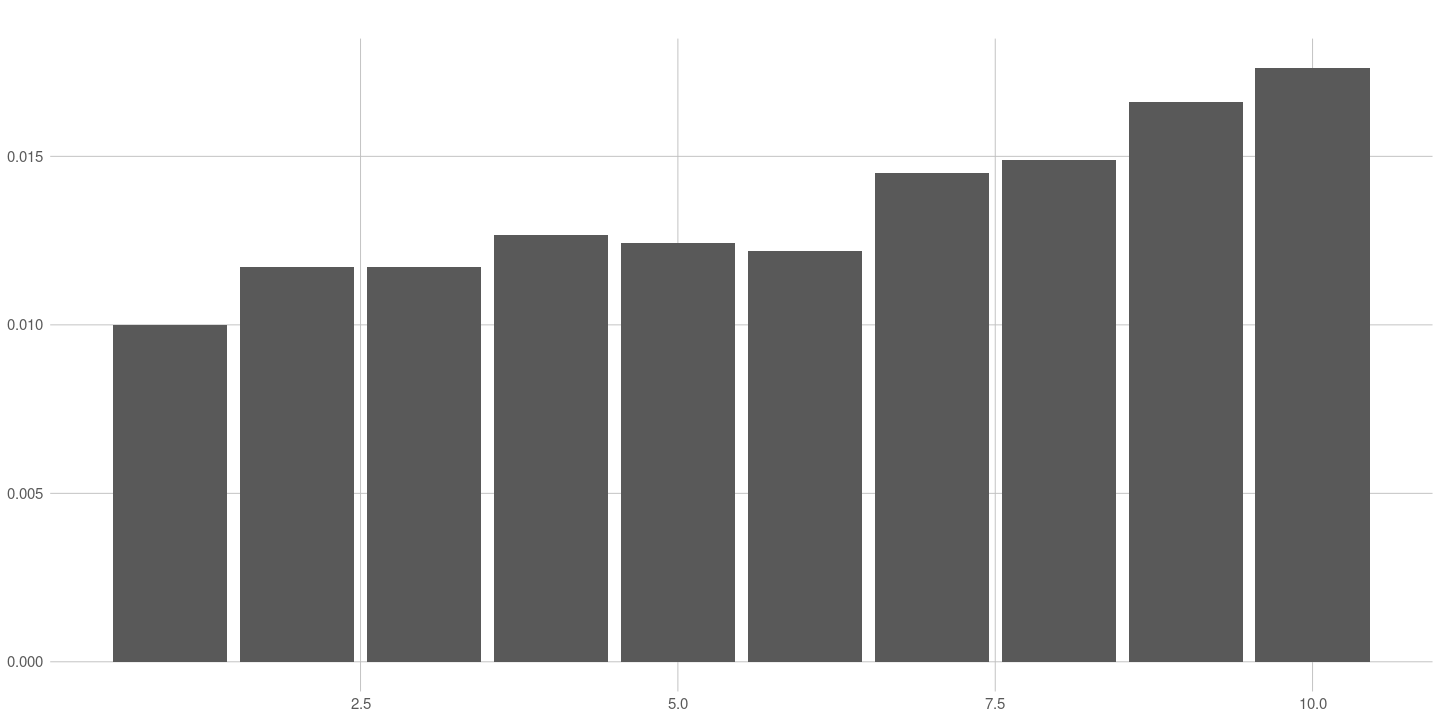

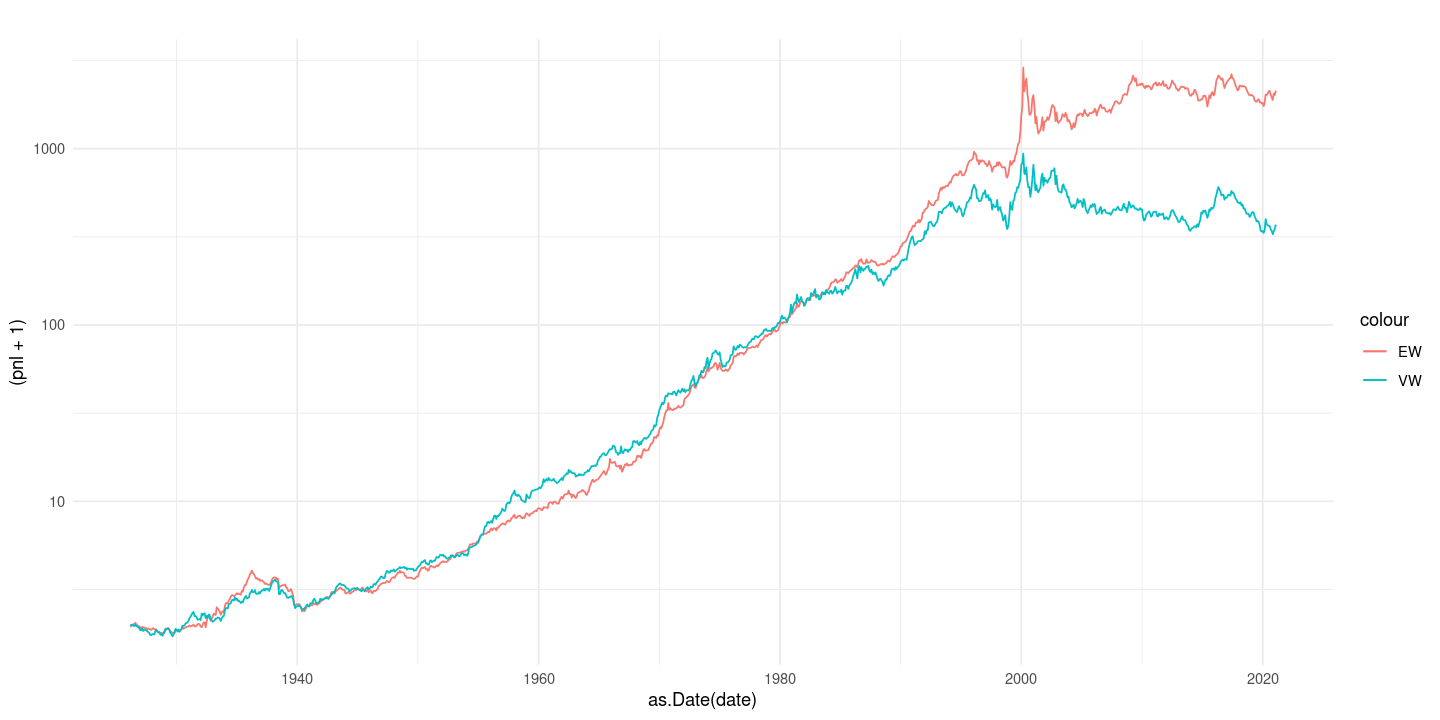

In [347]:
# This is a one month lag

fc2[,yearmonth:=month_index+1] # since these were returns last month, so align it to the next month
msf2=merge(fc2,msf,by=c('permno','yearmonth'), suffixes=c('.whatever',''))

msf2[!is.na(ret_tech_peers) & abs(prc_lag1)>=5 &  # $5 filter
             not_small==TRUE ,bin_tech_peers:=apply_quantiles(ret_tech_peers,bins=10),by=list(date)]
routine(msf2[  ,])

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).



                   model 1    model 2    model 3   model 4
Dependent Var.:         ew         vw         ew        vw
                                                          
Constant         0.0019    -0.0011     0.0054**   0.0016  
                (0.0018)   (0.0020)   (0.0020)   (0.0021) 
mkt_rf          -0.0267     0.0334    -0.1139*   -0.0340  
                (0.0433)   (0.0465)   (0.0475)   (0.0508) 
smb              0.2227***  0.1837**   0.1648*    0.1722* 
                (0.0609)   (0.0654)   (0.0685)   (0.0732) 
hml             -0.0031     0.0355    -0.2928*** -0.3104**
                (0.0631)   (0.0678)   (0.0881)   (0.0942) 
mom              0.4332***  0.4417***                     
                (0.0431)   (0.0463)                       
rmw                                   -0.1853*    0.0234  
                                      (0.0932)   (0.0996) 
cma                                    0.3739**   0.4660**
                                      (0.1391)   (0.1487

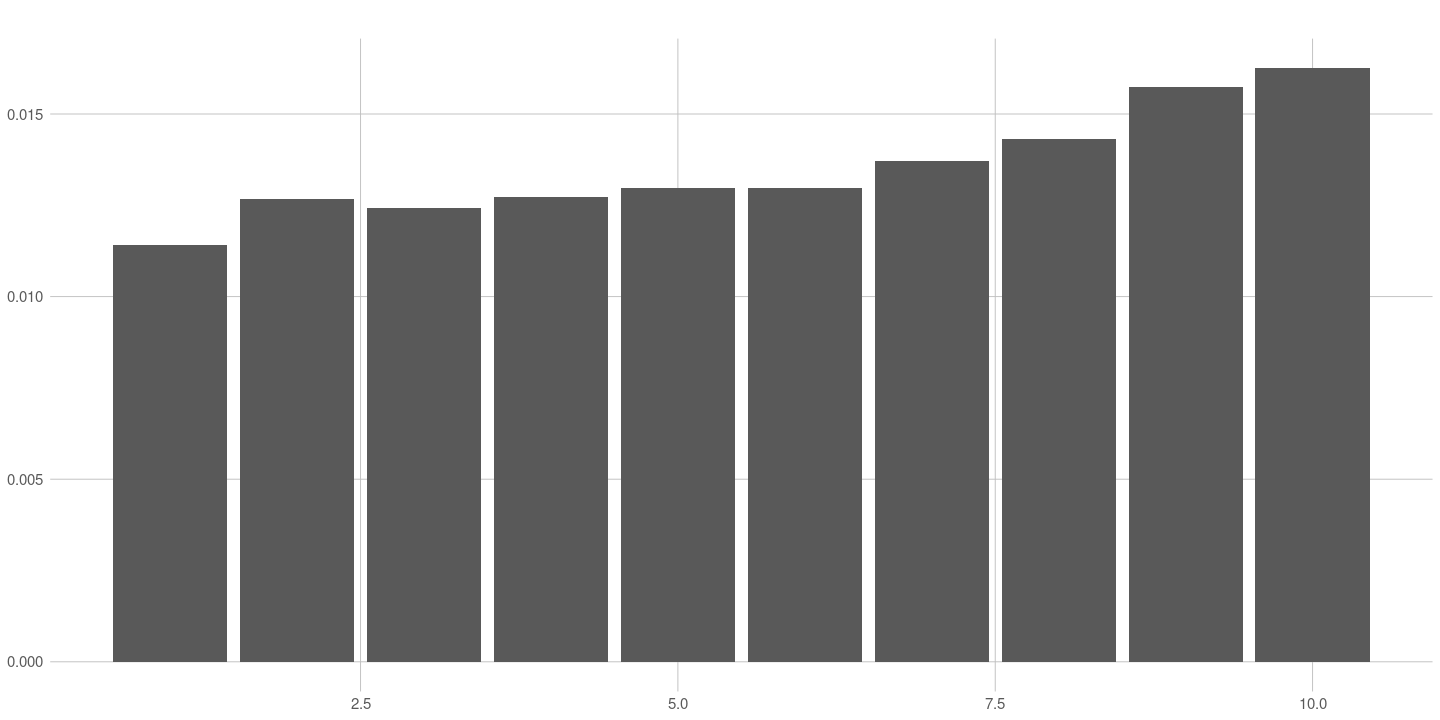

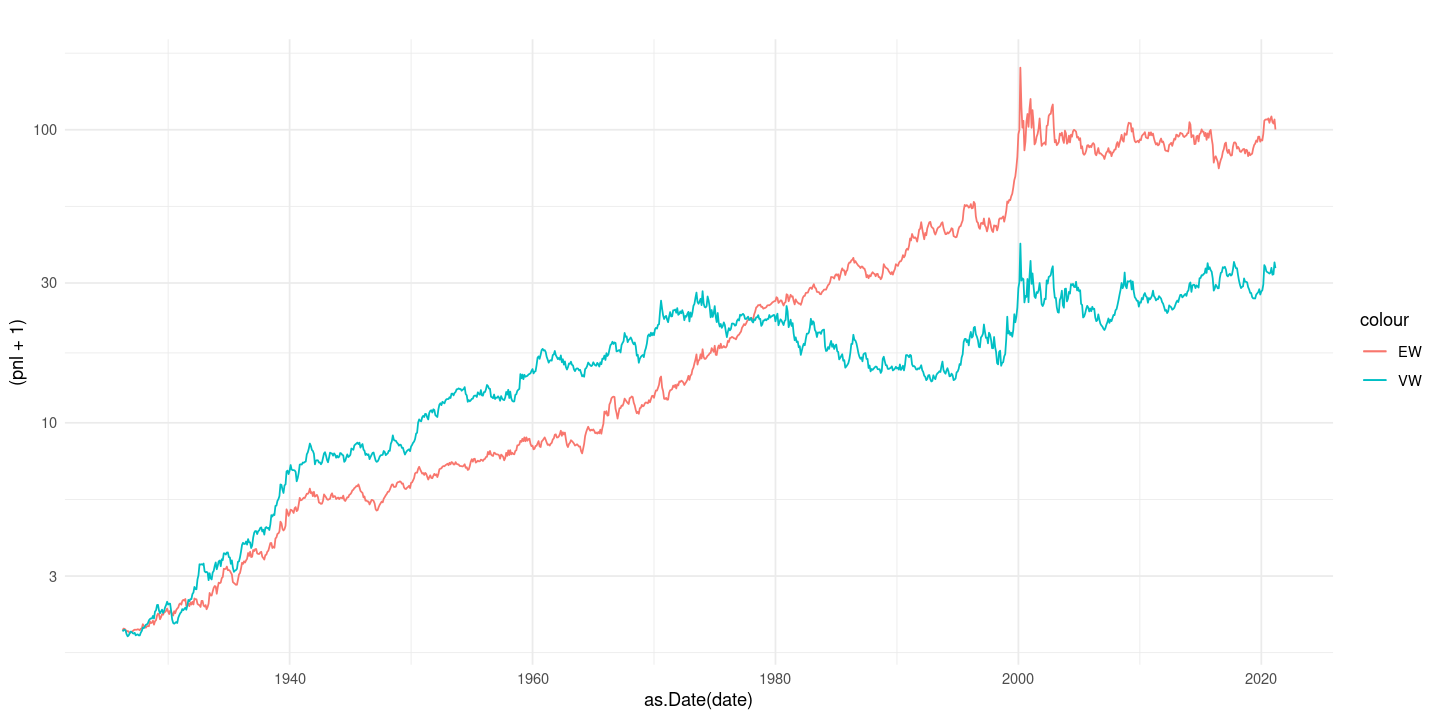

In [361]:
# THis is a two month lag. There isn't actually any "alpha"

fc2[,yearmonth:=month_index+2] 
msf2.twolags=merge(fc2,msf,by=c('permno','yearmonth'), suffixes=c('.whatever',''))

msf2.twolags[!is.na(ret_tech_peers) & abs(prc_lag1)>=5 &  # $5 filter
             not_small==TRUE ,bin_tech_peers:=apply_quantiles(ret_tech_peers,bins=10),by=list(date)]
routine(msf2.twolags[  ,])

# improvements

# calculate the information discreteness measure
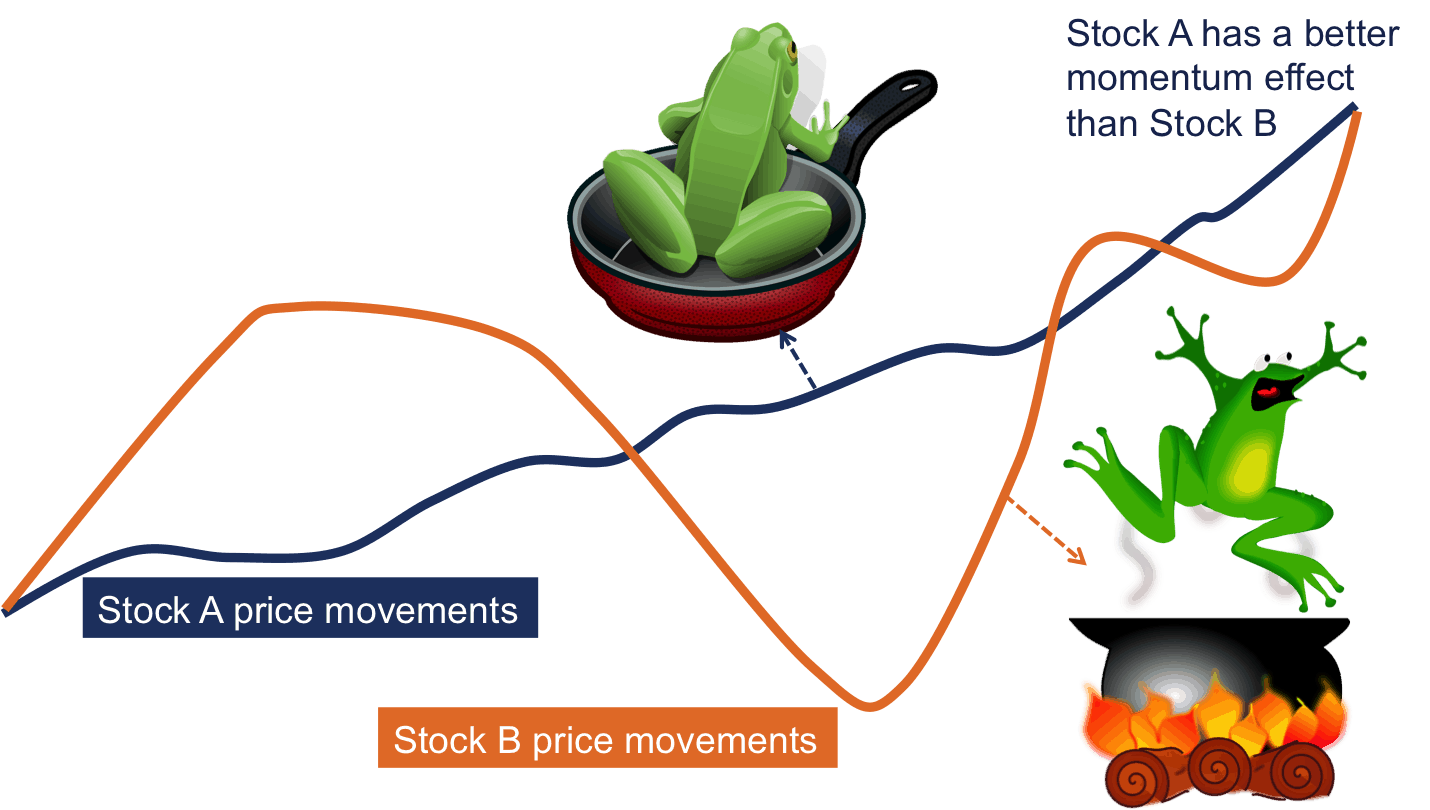

In [235]:
x[,month_index:=year((date2))*12+month((date2))+2]
msg3=merge(x,msf2.twolags,by=c('permno','month_index'), suffixes=c('.whatever',''))
msf3[,bin_tech_peers:=NULL]
msf3[,bin_mcap:=apply_quantiles(mcap_lag1),by=list(date)]
msf3[,bin_tech_peers:=NULL]
msf3[prc_lag1>=5 & bin_mcap>=2,bin_tech_peers:=apply_quantiles(ret_tech_peers,bins=5),by=list(date)]

msf3[,ID2_high:=apply_quantiles(ID_nozero,bins=2),by=list(bin_tech_peers,yearmonth)]


Warning message in `[.data.table`(msf3, , `:=`(bin_tech_peers, NULL)):
“Column 'bin_tech_peers' does not exist to remove”


  x freq
1 1  408
2 2  408
3 3  408
4 4  408
5 5  408
[1] 5


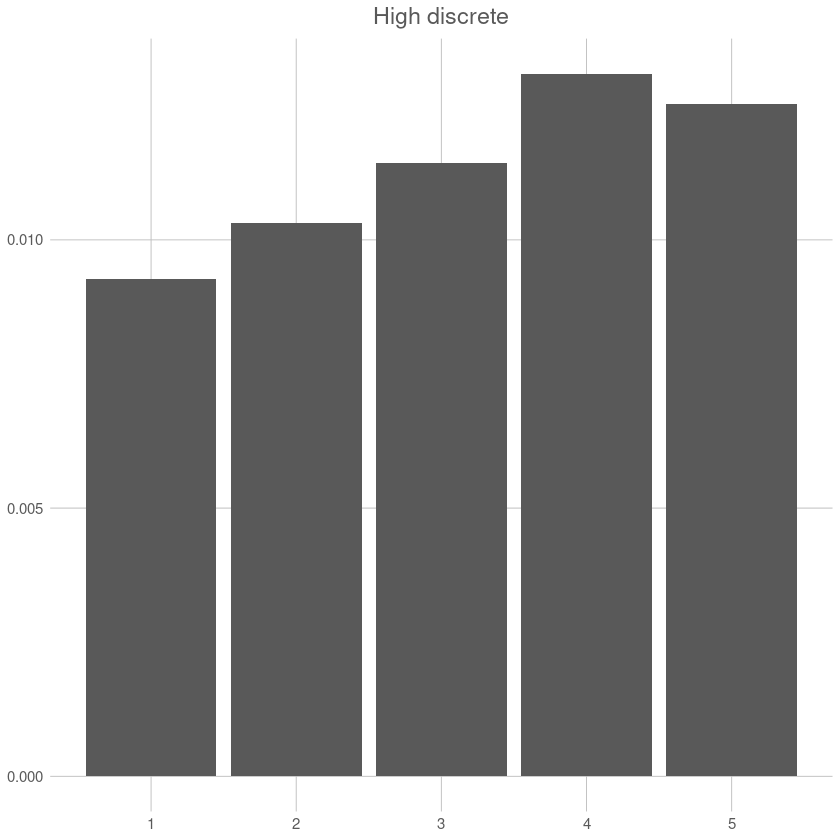

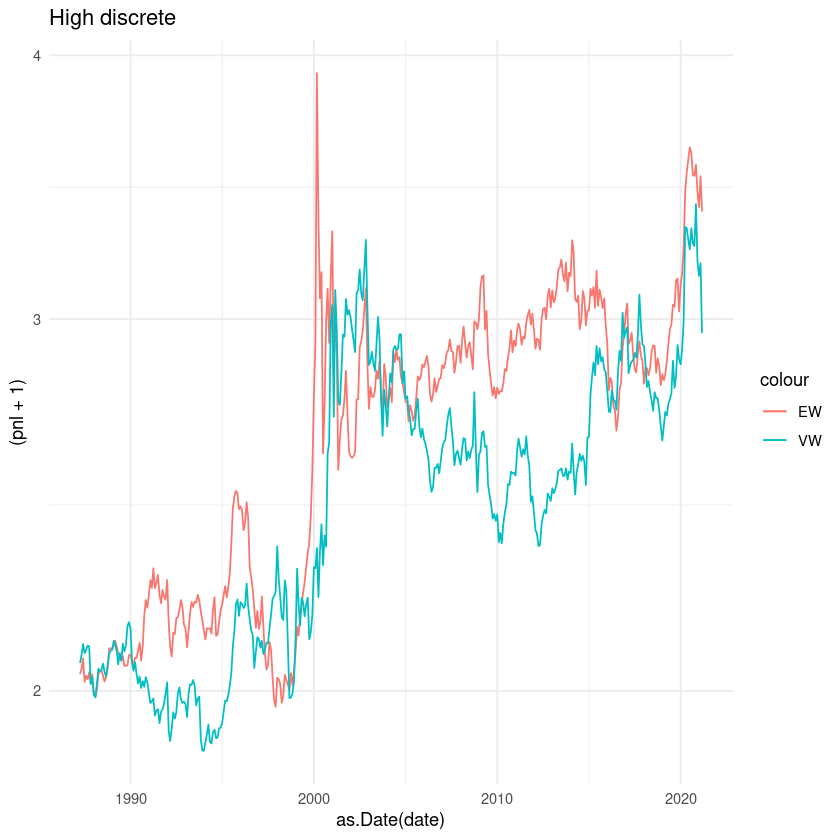

In [236]:
routine(msf3[ID2_high==2,],'High discrete')


  x freq
1 1  408
2 2  408
3 3  408
4 4  408
5 5  408
[1] 5


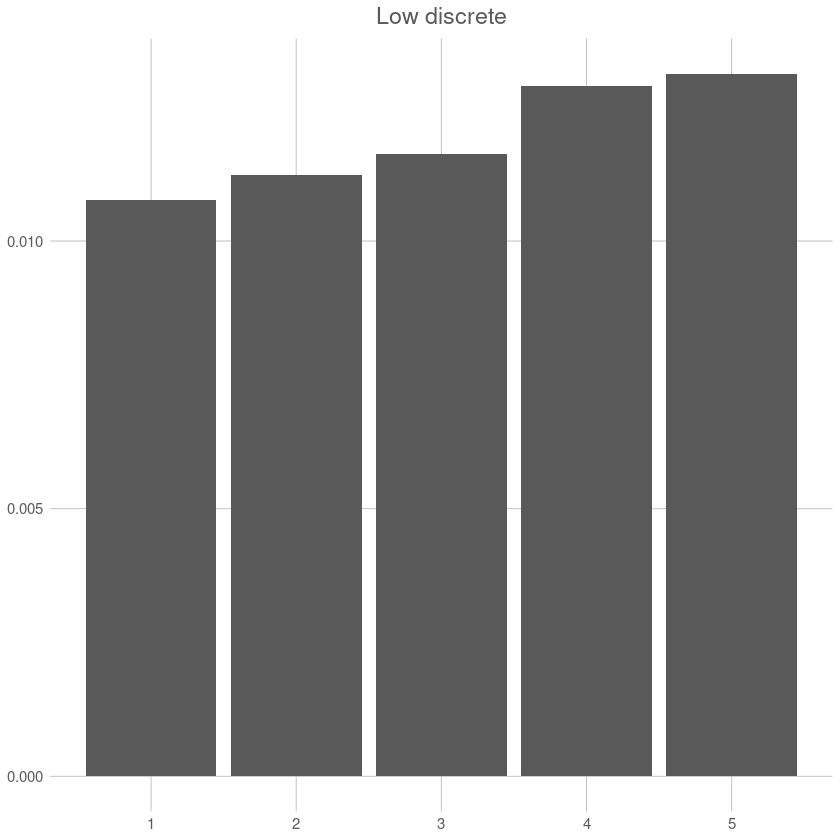

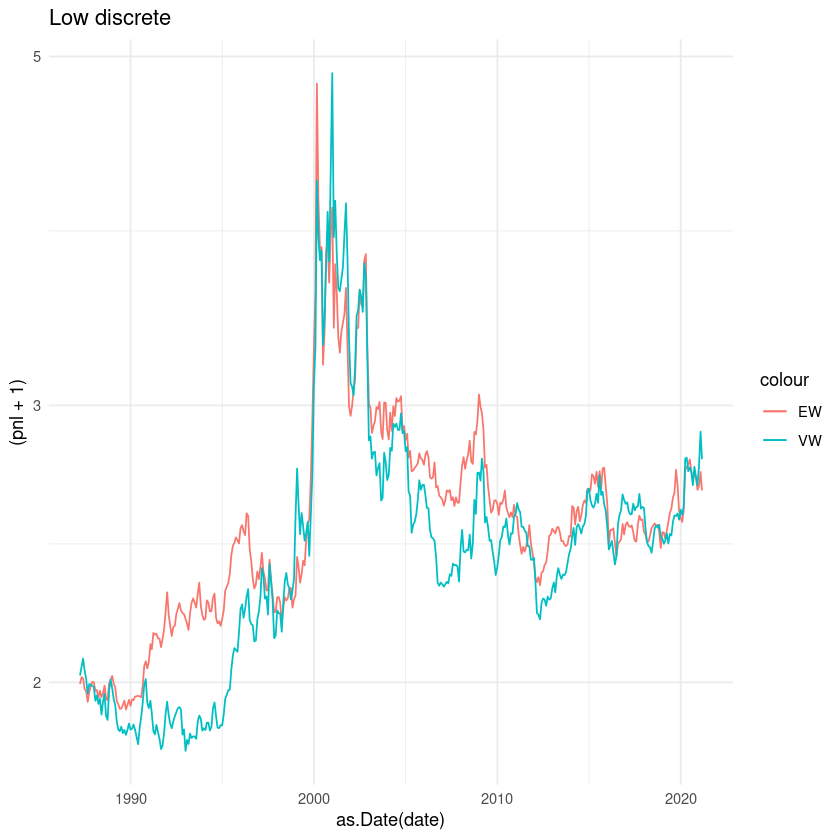

In [237]:
routine(msf3[ID2_high==1,],'Low discrete')


# tech peer matrix is very dense.
* the average firm has too many peers --> maybe we find the absolutely very best
* there's also the possibility investors have learned


summary(msf2)

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).



                   model 1    model 2    model 3   model 4
Dependent Var.:         ew         vw         ew        vw
                                                          
Constant         0.0020    -0.0026     0.0056**  -5.46e-5 
                (0.0018)   (0.0020)   (0.0020)   (0.0022) 
mkt_rf          -0.0441     0.0374    -0.1380**  -0.0336  
                (0.0432)   (0.0478)   (0.0479)   (0.0519) 
smb              0.3116***  0.2101**   0.2603***  0.2157**
                (0.0607)   (0.0672)   (0.0689)   (0.0748) 
hml              0.0218     0.0139    -0.2721**  -0.2861**
                (0.0629)   (0.0696)   (0.0887)   (0.0963) 
mom              0.4589***  0.4273***                     
                (0.0429)   (0.0475)                       
rmw                                   -0.1527     0.0949  
                                      (0.0938)   (0.1018) 
cma                                    0.3570*    0.3549* 
                                      (0.1402)   (0.1520

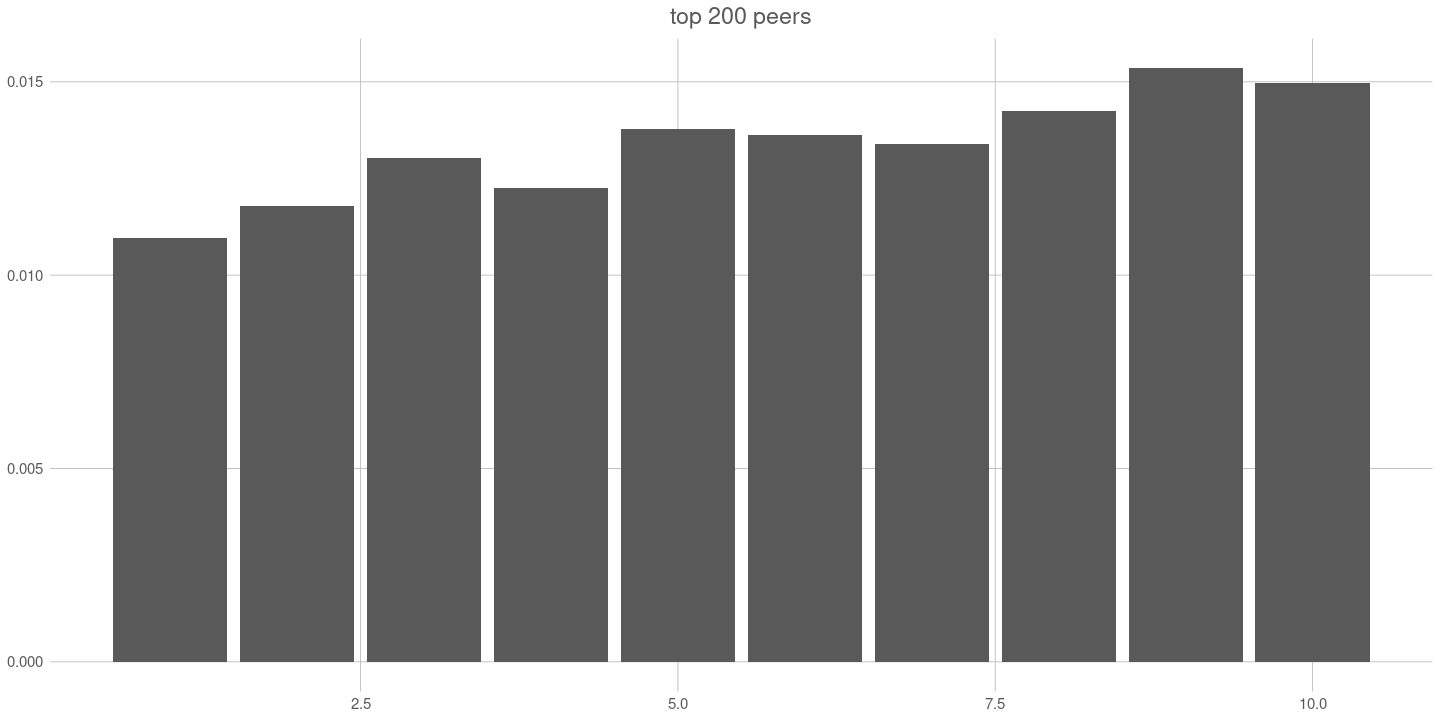

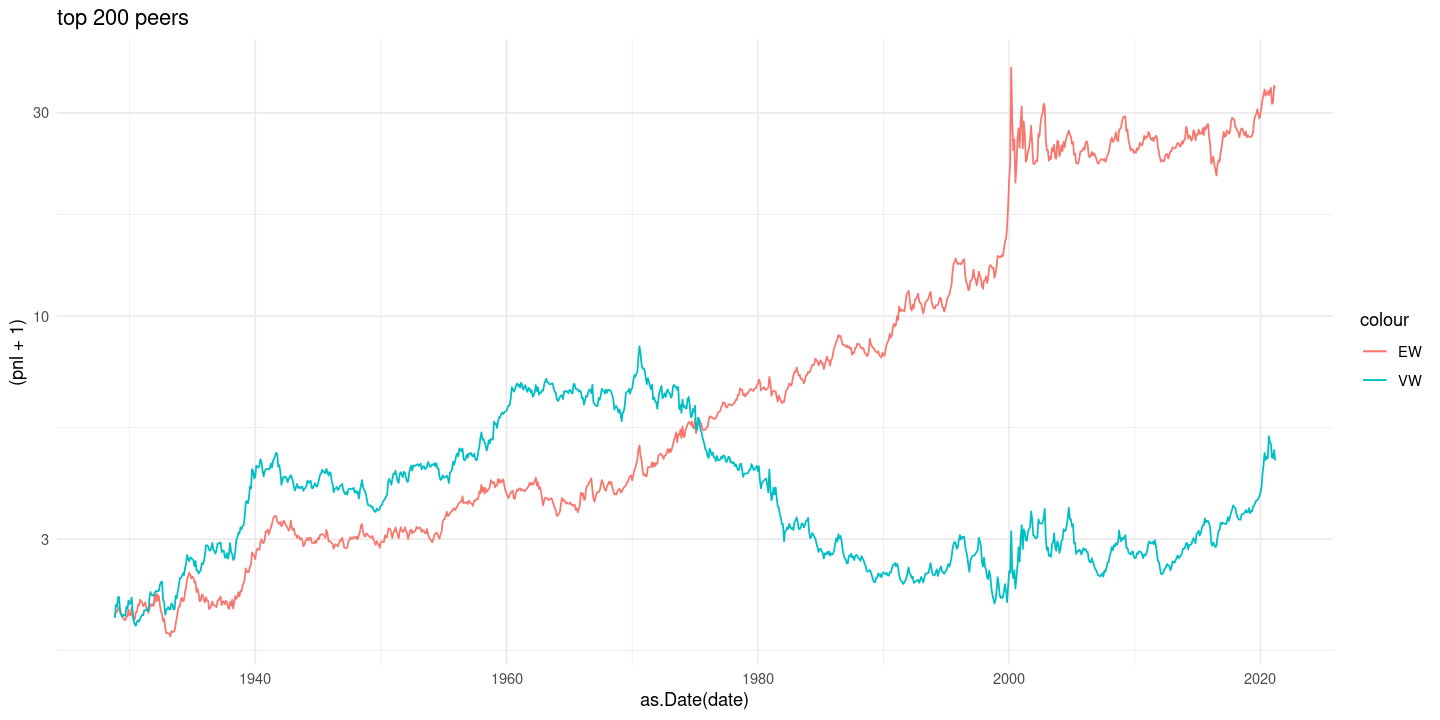

In [364]:
# go after the to p200 using the two month lag version
msf2.twolags[,bin_tech_peers:=NULL]
msf2.twolags[,hasenough:=n_distinct(ret_tech_focaltop200)>=200,by=list(date)]
msf2.twolags[prc_lag1>=5 & not_small & hasenough,bin_tech_peers:=apply_quantiles(ret_tech_focaltop200,bins=10),
     by=list(date)]
routine(msf2.twolags[,],'top 200 peers')


NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).



                   model 1    model 2    model 3  model 4
Dependent Var.:         ew         vw         ew       vw
                                                         
Constant         0.0004    -0.0026     0.0026    -0.0001 
                (0.0013)   (0.0016)   (0.0014)   (0.0017)
mkt_rf          -0.0682*    0.0104    -0.1227*** -0.0590 
                (0.0310)   (0.0379)   (0.0335)   (0.0415)
smb              0.1388**   0.0569     0.0999*    0.0522 
                (0.0436)   (0.0532)   (0.0482)   (0.0597)
hml             -0.0090     0.0721    -0.1895**  -0.1425 
                (0.0452)   (0.0552)   (0.0621)   (0.0769)
mom              0.2689***  0.3545***                    
                (0.0308)   (0.0376)                      
rmw                                   -0.1282     0.0357 
                                      (0.0656)   (0.0813)
cma                                    0.2358*    0.2189 
                                      (0.0980)   (0.1214)
______________

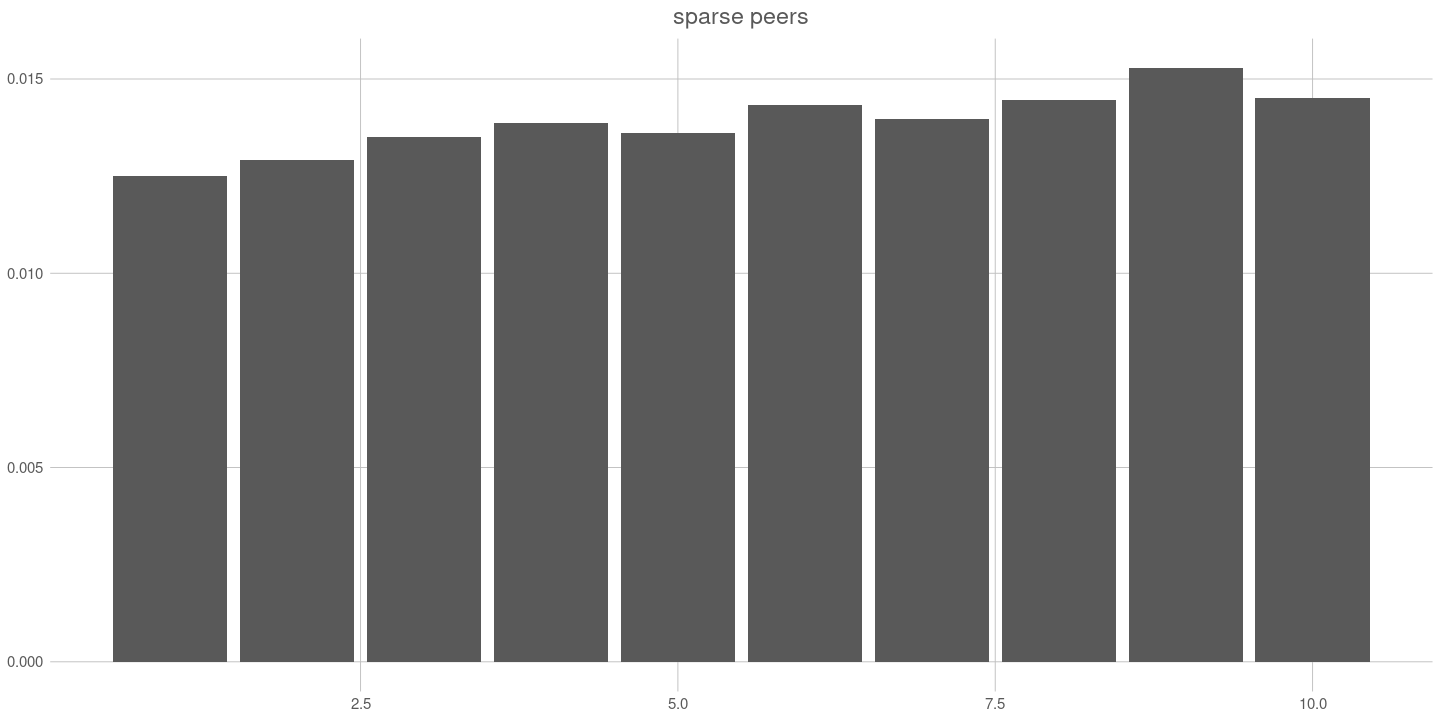

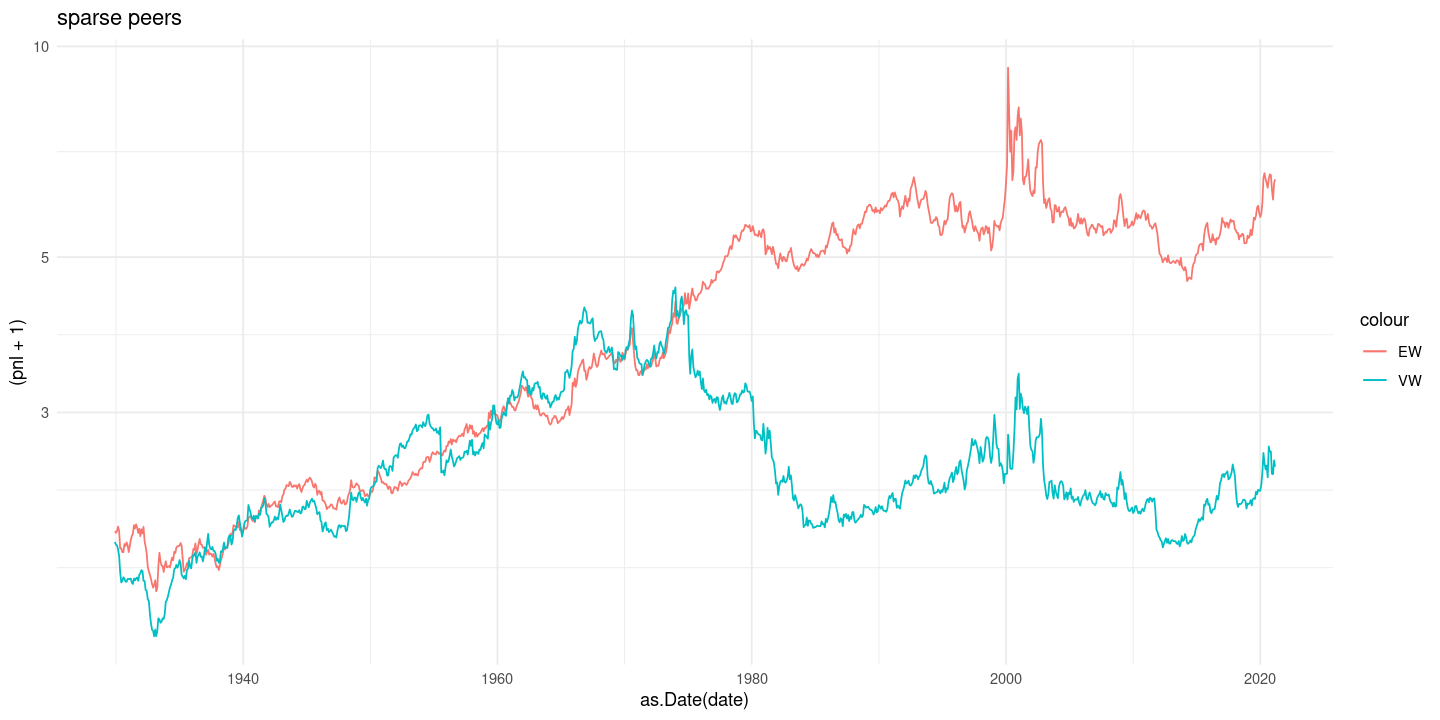

In [363]:
# go after the top 30 using the two month lag version
msf2.twolags[,bin_tech_peers:=NULL]
msf2.twolags[,hasenough:=n_distinct(ret_tech_focaltop30)>=200,by=list(date)]
msf2.twolags[prc_lag1>=5 & not_small & hasenough,bin_tech_peers:=apply_quantiles(ret_tech_focaltop30,bins=10),
     by=list(date)]
routine(msf2.twolags[,],'sparse peers')

# Continuous momentum 
1. First sort on tech momentum
2. Then sort on discreteness 

Tends to produce higher returns but doesn't correct the decline in the strategy

In [368]:
x[,month_index:=year((date2))*12+month((date2))+2]
msf3=merge(x,msf2.twolags,by=c('permno','month_index'), suffixes=c('.whatever',''))
msf3[,bin_tech_peers:=NULL]
msf3[,bin_mcap:=apply_quantiles(mcap_lag1),by=list(date)]
msf3[,bin_tech_peers:=NULL]

msf3[,hasenough:=n_distinct(ret_tech_peers)>=100,by=list(date)]
msf3[prc_lag1>=5 & not_small & hasenough,bin_tech_peers:=apply_quantiles(ret_tech_peers,bins=5),
     by=list(date)]

msf3[,ID2_high:=apply_quantiles(ID2_nozero,bins=2),by=list(bin_tech_peers,yearmonth)]



Warning message in `[.data.table`(msf3, , `:=`(bin_tech_peers, NULL)):
“Column 'bin_tech_peers' does not exist to remove”


NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).



                   model 1    model 2   model 3    model 4
Dependent Var.:         ew         vw        ew         vw
                                                          
Constant         0.0009    -0.0008     0.0034    0.0016   
                (0.0017)   (0.0019)   (0.0018)  (0.0020)  
mkt_rf          -0.0203     0.0532    -0.0818   -0.0039   
                (0.0396)   (0.0440)   (0.0431)  (0.0478)  
smb              0.1353*    0.0500     0.1070    0.0358   
                (0.0557)   (0.0619)   (0.0621)  (0.0688)  
hml              0.0170     0.0676    -0.2619** -0.2657** 
                (0.0577)   (0.0641)   (0.0799)  (0.0885)  
mom              0.3667***  0.4015***                     
                (0.0394)   (0.0437)                       
rmw                                   -0.0637    0.0058   
                                      (0.0845)  (0.0936)  
cma                                    0.3815**  0.4723***
                                      (0.1262)  (0.1398)

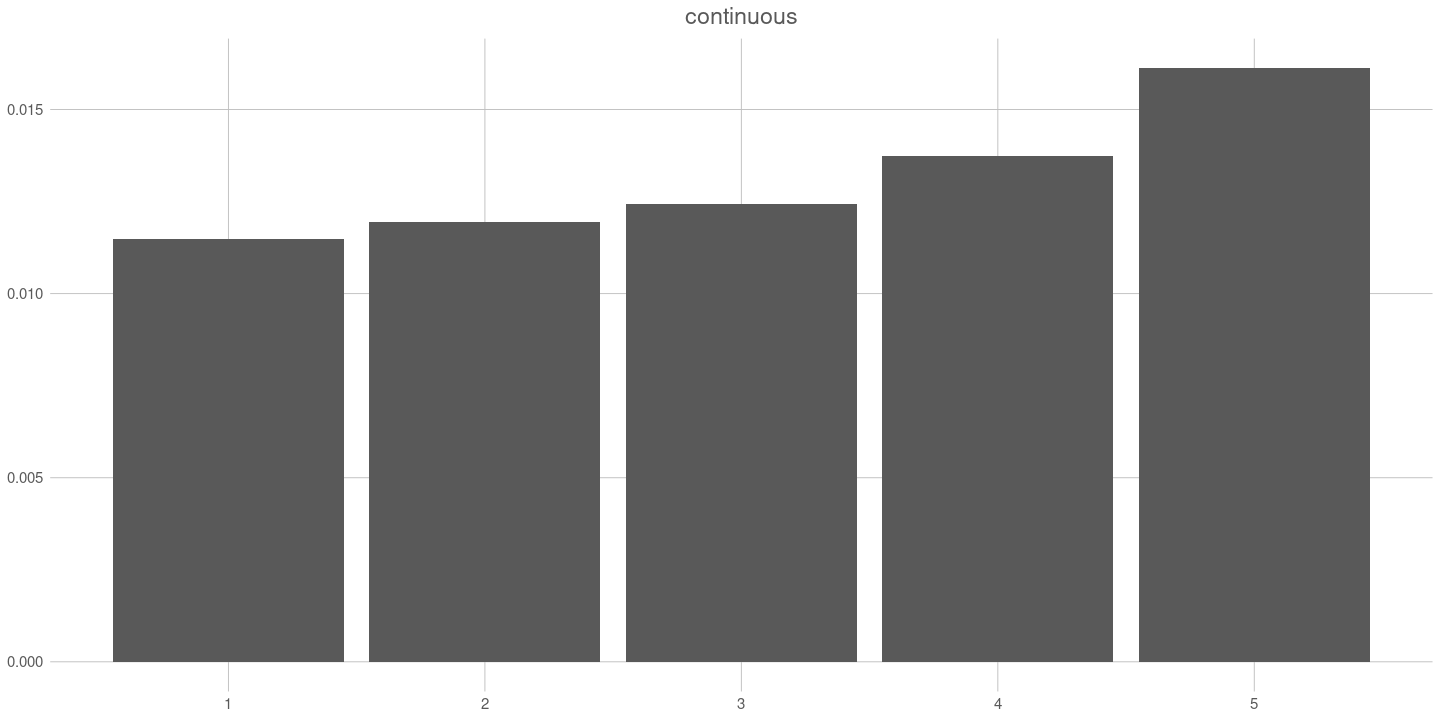

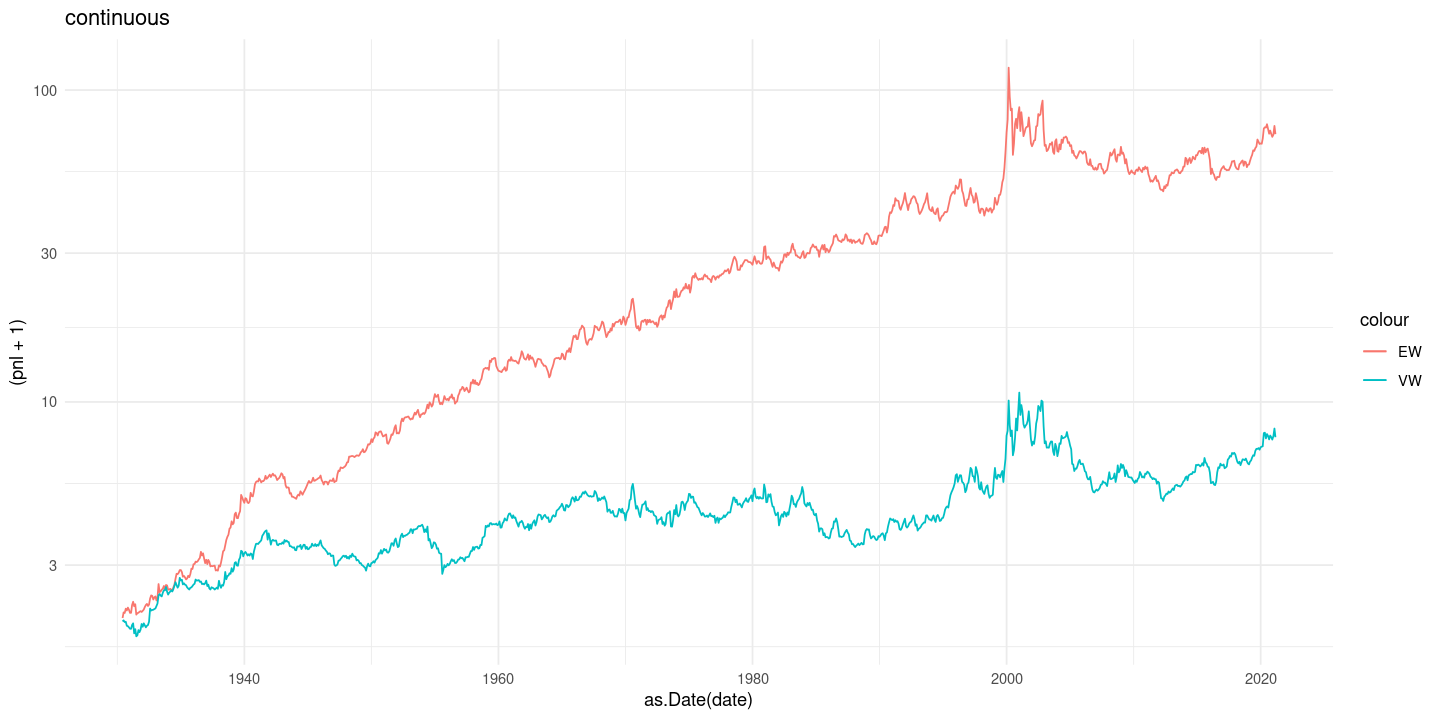

In [369]:
routine(msf3[ID2_high==1,],'continuous')

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).



                   model 1    model 2    model 3    model 4
Dependent Var.:         ew         vw         ew         vw
                                                           
Constant         0.0003    -0.0012     0.0030    -0.0004   
                (0.0016)   (0.0017)   (0.0017)   (0.0018)  
mkt_rf          -0.0543    -0.0086    -0.1169**  -0.0295   
                (0.0375)   (0.0400)   (0.0410)   (0.0426)  
smb              0.1470**   0.0284     0.0976     0.0757   
                (0.0528)   (0.0562)   (0.0590)   (0.0613)  
hml             -0.0050     0.1400*   -0.3104*** -0.2084** 
                (0.0547)   (0.0583)   (0.0760)   (0.0789)  
mom              0.3786***  0.3407***                      
                (0.0373)   (0.0398)                        
rmw                                   -0.1540     0.2705** 
                                      (0.0803)   (0.0835)  
cma                                    0.4517***  0.5128***
                                      (0

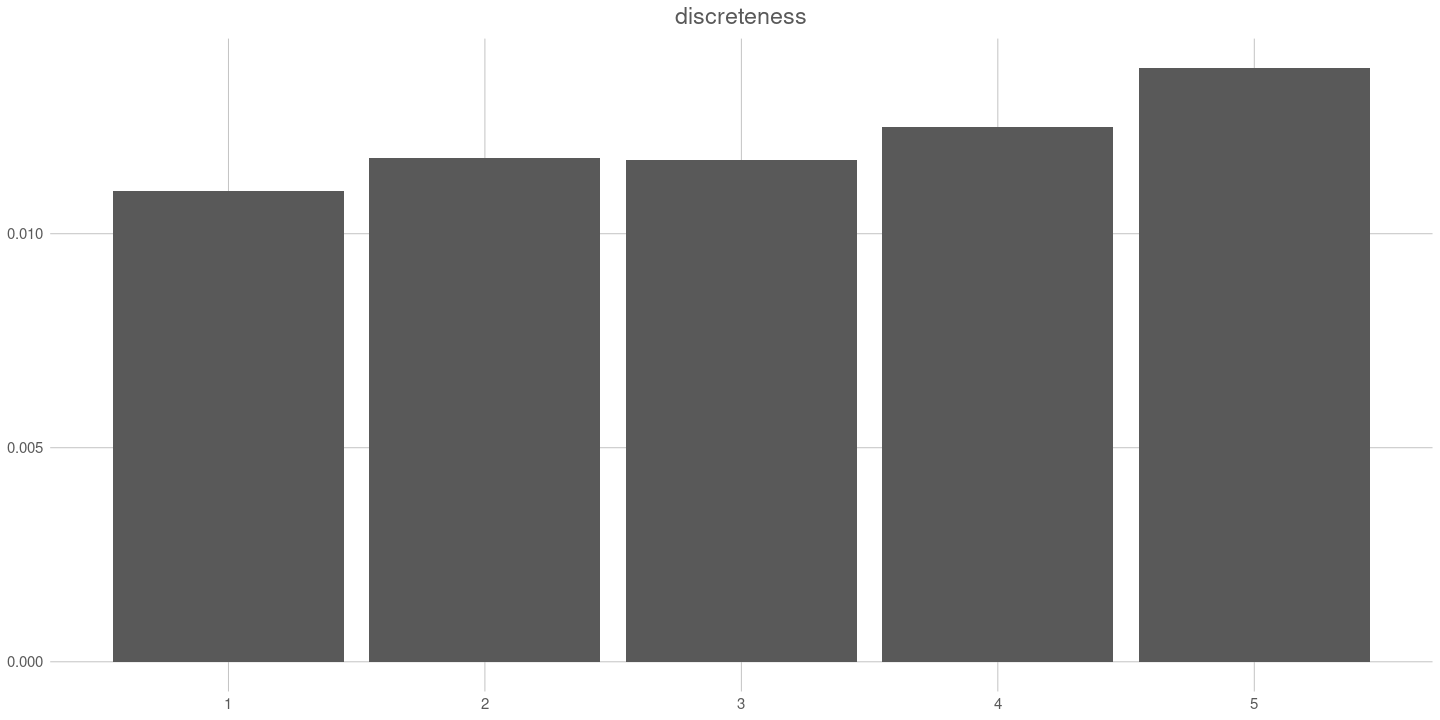

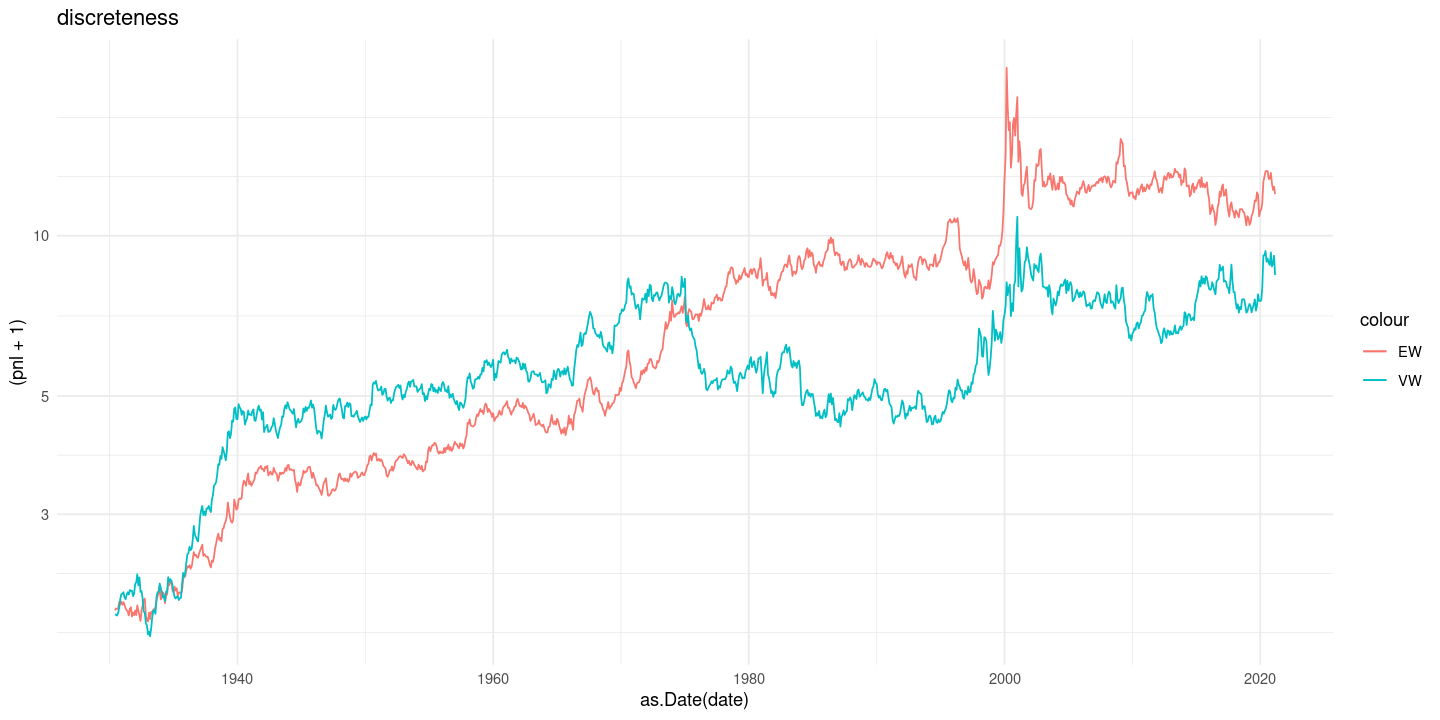

In [370]:
routine(msf3[ID2_high==2,],'discreteness')

In [372]:
x[,month_index:=year((date2))*12+month((date2))+2]
msf3=merge(x,msf2.twolags,by=c('permno','month_index'), suffixes=c('.whatever',''))
msf3[,bin_tech_peers:=NULL]
msf3[,bin_mcap:=apply_quantiles(mcap_lag1),by=list(date)]
msf3[,bin_tech_peers:=NULL]

msf3[,hasenough:=n_distinct(ret_tech_peers)>=100,by=list(date)]
msf3[prc_lag1>=5 & not_small & hasenough,bin_tech_peers:=apply_quantiles(ret_tech_peers,bins=10),by=list(date)]

msf3[,ID2_high:=apply_quantiles(ID_nozero,bins=2),by=list(bin_tech_peers,yearmonth)]



Warning message in `[.data.table`(msf3, , `:=`(bin_tech_peers, NULL)):
“Column 'bin_tech_peers' does not exist to remove”


NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).



                   model 1    model 2   model 3  model 4
Dependent Var.:         ew         vw        ew       vw
                                                        
Constant         0.0011    -0.0019     0.0043*   0.0014 
                (0.0020)   (0.0023)   (0.0022)  (0.0025)
mkt_rf           0.0007     0.0860    -0.0842   -0.0063 
                (0.0476)   (0.0552)   (0.0520)  (0.0596)
smb              0.1962**   0.1382     0.1676*   0.1243 
                (0.0669)   (0.0776)   (0.0749)  (0.0859)
hml              0.0379     0.0498    -0.2543** -0.2174*
                (0.0693)   (0.0804)   (0.0964)  (0.1105)
mom              0.4436***  0.4542***                   
                (0.0473)   (0.0549)                     
rmw                                   -0.0548    0.0106 
                                      (0.1019)  (0.1169)
cma                                    0.3485*   0.2681 
                                      (0.1522)  (0.1745)
_______________ __________ ____

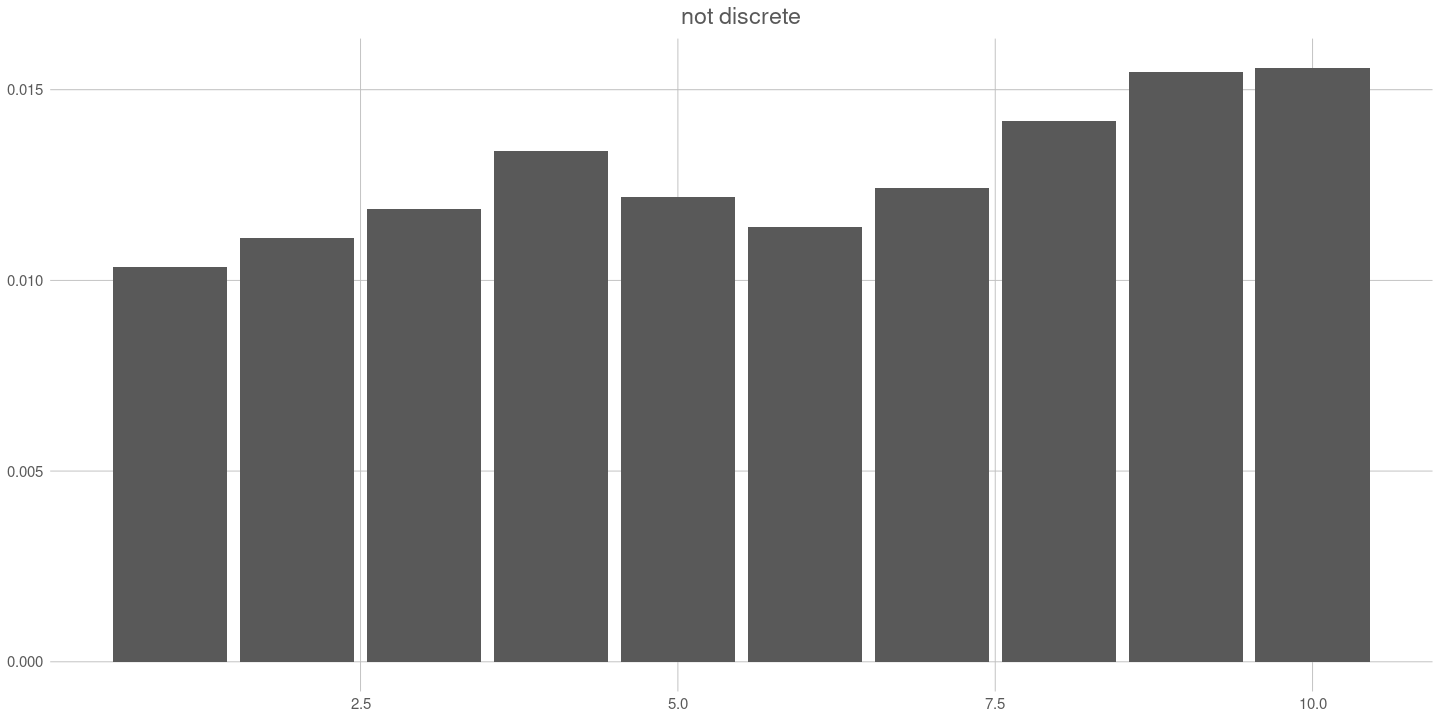

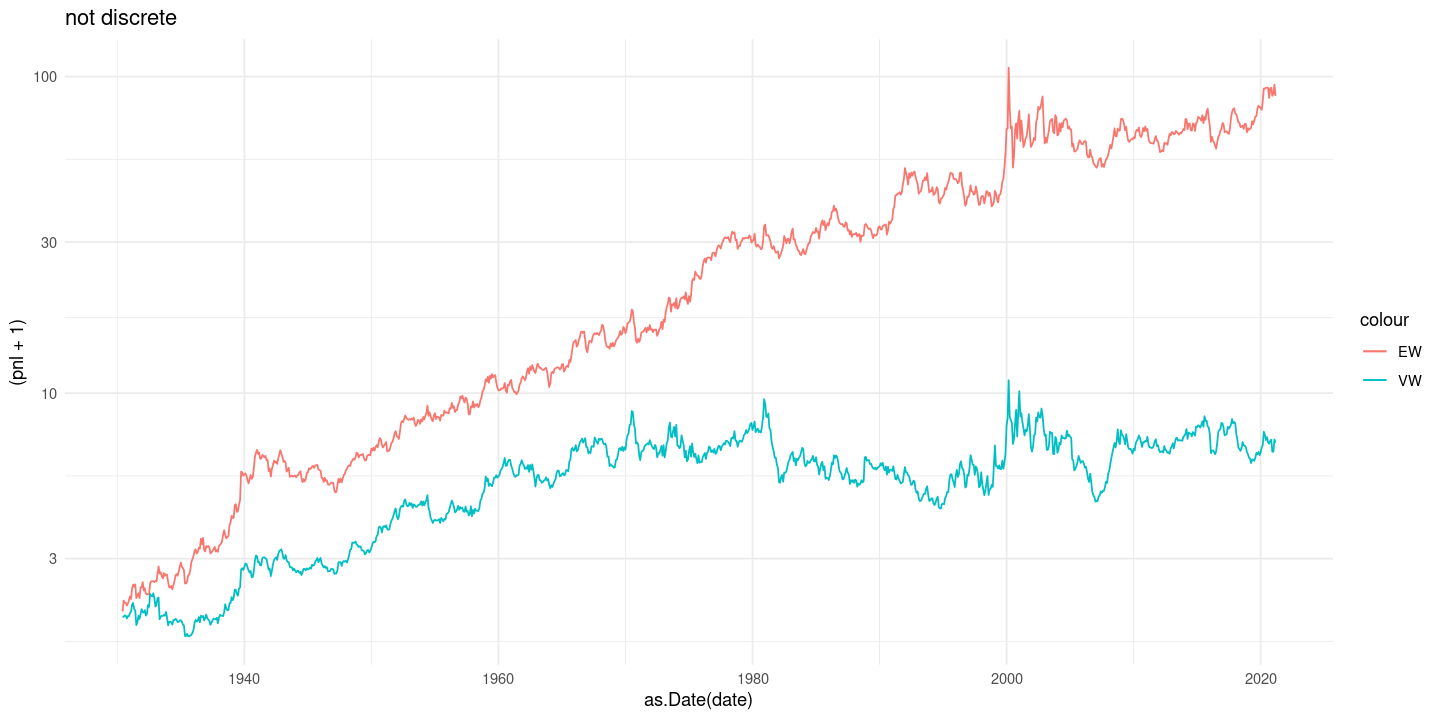

In [374]:
routine(msf3[ID2_high==1,],'not discrete')

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).

NOTE: 1 observation removed because of NA values (RHS: 1).



                   model 1    model 2    model 3    model 4
Dependent Var.:         ew         vw         ew         vw
                                                           
Constant         0.0002     0.0004     0.0035     0.0021   
                (0.0020)   (0.0023)   (0.0021)   (0.0024)  
mkt_rf          -0.0461    -0.0573    -0.1240*   -0.0956   
                (0.0464)   (0.0535)   (0.0508)   (0.0571)  
smb              0.1747**   0.1879*    0.1277     0.2091*  
                (0.0653)   (0.0753)   (0.0731)   (0.0822)  
hml              0.0364     0.0143    -0.3140*** -0.4076***
                (0.0676)   (0.0780)   (0.0941)   (0.1058)  
mom              0.4566***  0.4309***                      
                (0.0461)   (0.0532)                        
rmw                                   -0.1314     0.1709   
                                      (0.0995)   (0.1119)  
cma                                    0.4918***  0.6330***
                                      (0

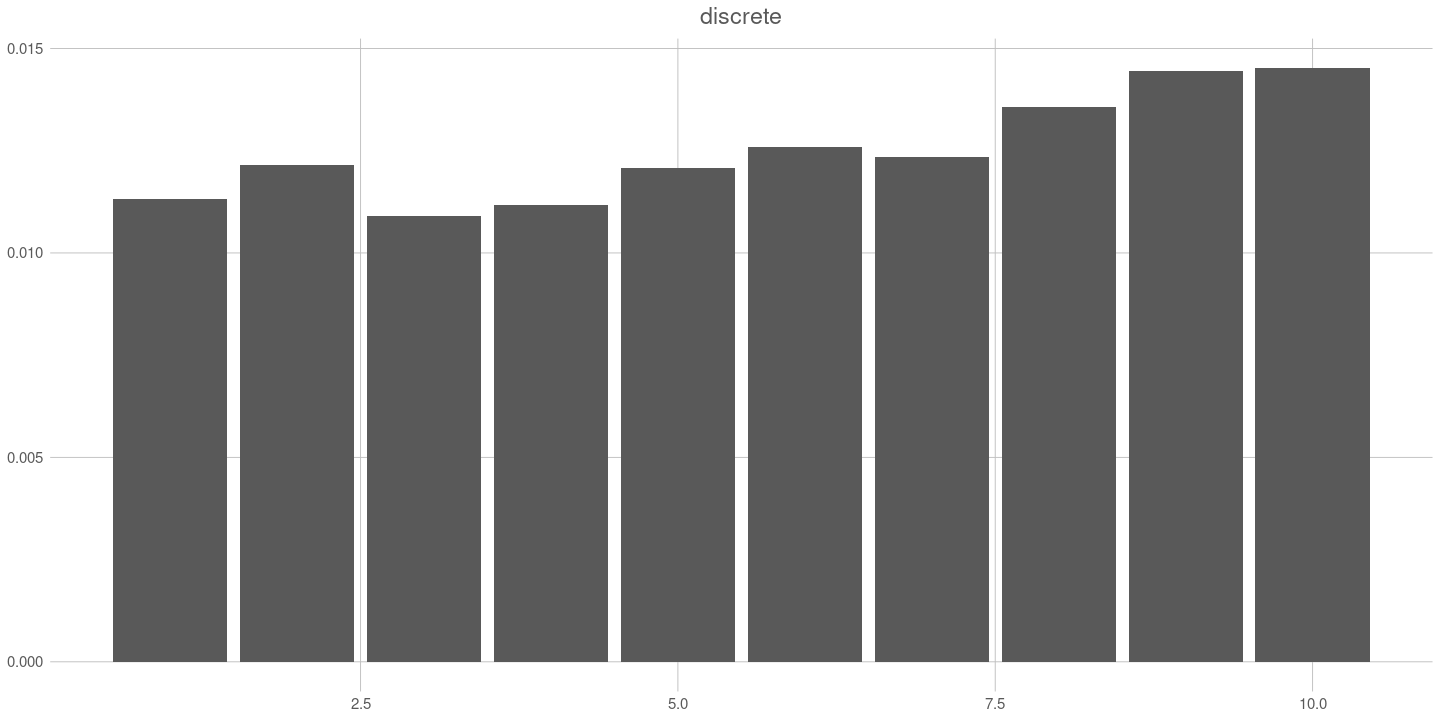

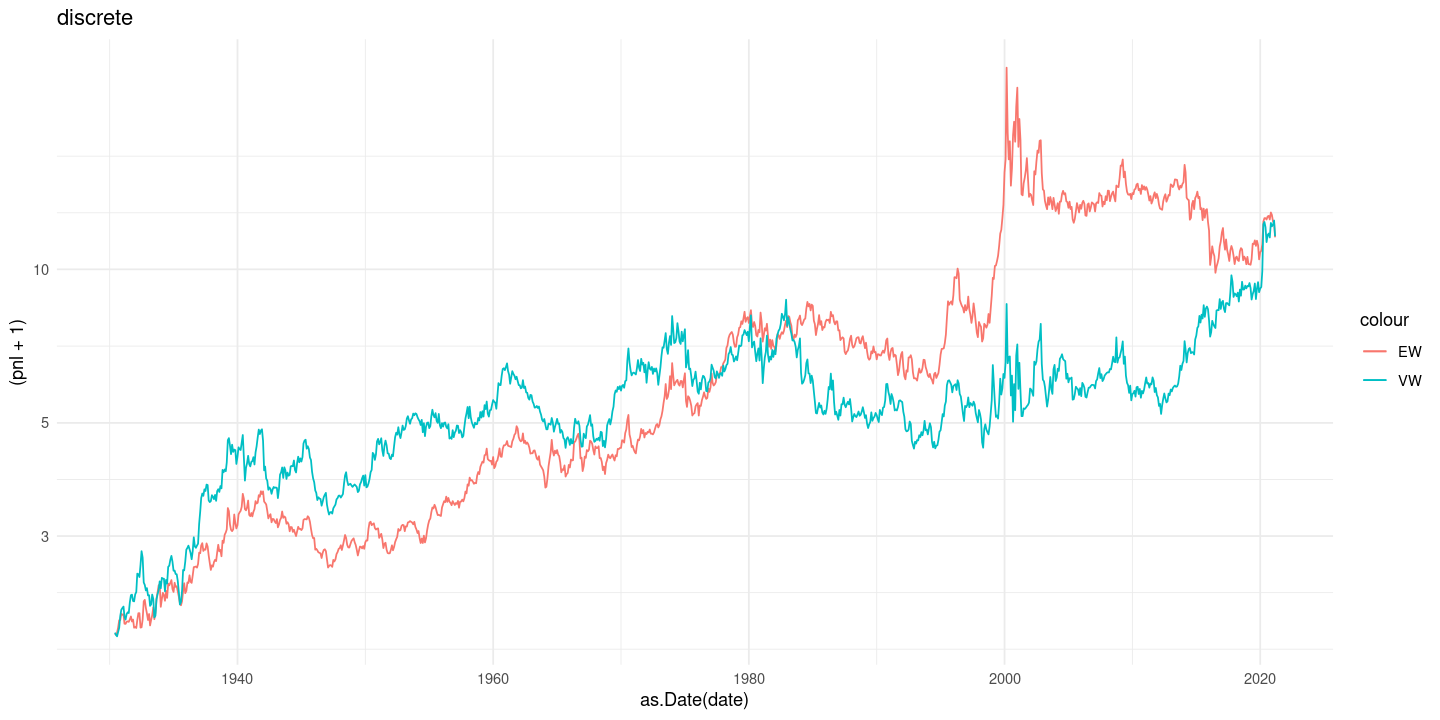

In [375]:
routine(msf3[ID2_high==2,],'discrete')

# one month lag instead

In [382]:
x[,month_index:=year((date2))*12+month((date2))+1]
msf3=merge(x,msf2,by=c('permno','month_index'), suffixes=c('.whatever',''))
msf3[,bin_tech_peers:=NULL]
msf3[,bin_mcap:=apply_quantiles(mcap_lag1),by=list(date)]
msf3[,bin_tech_peers:=NULL]

msf3[,hasenough:=n_distinct(ret_tech_peers)>=100,by=list(date)]
msf3[prc_lag1>=5 & not_small & hasenough,bin_tech_peers:=apply_quantiles(ret_tech_peers,bins=5),
     by=list(date)]

msf3[,ID2_high:=apply_quantiles(ID2_nozero,bins=2),by=list(bin_tech_peers,yearmonth)]



Warning message in `[.data.table`(msf3, , `:=`(bin_tech_peers, NULL)):
“Column 'bin_tech_peers' does not exist to remove”


In [ ]:
routine(msf3[ID2_high==3,],'discrete')


In [ ]:
routine(msf3[ID2_high==1,],'continuous')

# weekly?

In [387]:

res=queryClickhouseDbPublic("
    select *,toStartOfWeek(date(date)+14) as week_start from 
 class.focalreturn_weekly

")

ret=queryClickhouseDbPublic("

    select permno,toStartOfWeek(date(date)) as week_start,
        avg(abs(prc)) as prc_final,
        avg(abs(prc*shrout)) as mcap,
        exp(sum(ln(1+ret)))-1 as ret,
        sum(vol) as volume
    from crsp.dsf 
    inner join crsp.dsenames
        using(permno)
    where date between start and end
    and shrcd in (10,11) and hexcd in (1,2,3) and 
    date>='1960-01-01'
    group by all
")
setnames(ret,'prc_final','prc')
head(ret)
head(res)



3.371 sec elapsed
11.261 sec elapsed


permno,week_start,prc,mcap,ret,volume
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
77476,1994-04-24,24.000,1045579.41,-2.072539e-02,94600
84129,2014-05-04,28.760,5317580.24,6.934840e-03,11819593
58246,1976-11-21,38.125,190625.00,6.600660e-03,NA
27254,1993-06-06,7.550,47912.30,6.779661e-03,15300
20239,1983-10-16,23.200,1248113.60,1.814311e-10,508400
11840,2002-03-24,0.645,7702.59,4.615390e-02,21030


focal_permno,date,ret_tech_peers,ret_tech_focaltop30,ret_tech_focaltop200,ret_tech_focaltop50,ret_tech_focaltop100,closness,num_peers,week_start
<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int64>,<date>
91823,2020-09-27,0.0002458765,0.0003884903,0.0002311995,-0.001705993,0.0002789923,9.285421,180,2020-10-11
12117,1991-01-27,0.0348374401,0.0353641575,0.0348374401,0.034407919,0.0348374401,5.894248,62,1991-02-10
28118,1993-11-07,0.0114622018,0.0323620316,0.0083374320,0.013549995,0.0096616208,34.720131,398,1993-11-21
21179,1990-12-09,-0.0086281748,-0.0143007511,-0.0092453769,-0.026743902,-0.0140437848,63.091656,398,1990-12-23
77774,2010-08-29,0.0401422797,0.0506299248,0.0390316395,0.059217894,0.0449848477,60.315155,280,2010-09-12
89931,2000-03-19,-0.0064475789,-0.0138001935,-0.0067437249,-0.003349654,-0.0300500553,104.718398,306,2000-04-02


In [408]:
res[,permno:=focal_permno]
res2=merge(ret,res,by=c('permno','week_start'))

setkey(res2,permno,week_start)
res2[,prc_lag1:=shift(prc,type='lag'),by=permno]
res2[,mcap_lag1:=shift(mcap,type='lag'),by=permno]
res2[,vol_lag1:=shift(volume,type='lag'),by=permno]

# do lag 2
res2[,prc_lag2:=shift(prc,2,type='lag'),by=permno]
res2[,mcap_lag2:=shift(mcap,2,type='lag'),by=permno]
res2[,vol_lag2:=shift(volume,2,type='lag'),by=permno]




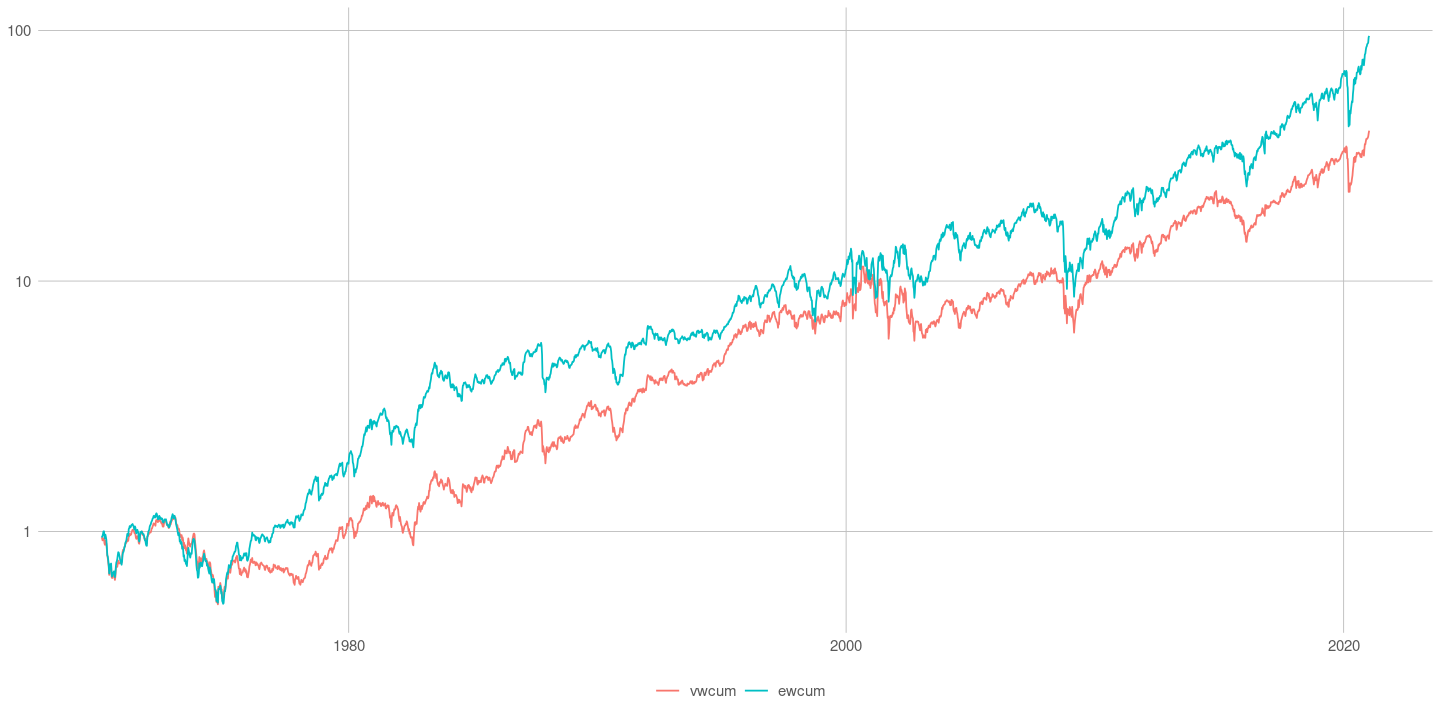

In [409]:

res2[,mcap_small:=mcap_lag2<=quantile(mcap_lag1,probs=0.2,na.rm=TRUE),by=list(week_start)]
res3=res2[prc_lag1>=5 & mcap_small==FALSE,]
res3[,bin:=apply_quantiles(ret_tech_peers ),by=list(date=week_start)]

bins=res3[!is.na(ret) ,list(ew=mean(ret),vw=weighted.mean(ret,mcap_lag1) ),by=list(week_start,bin)][!is.na(vw),]

bins2=merge(bins[bin %in% seq(1),list(ew,week_start,vw)] ,
bins[bin %in% seq(10),list(ew,week_start,vw)] ,suffixes=c('_long','_short'))

bins2 %>% setkey(week_start)


bins2[,vwcum:=cumprod(1+vw)][,ewcum:=cumprod(1+ew)]

# text size 12
library(repr)

# Change plot size to 4 x 3
options(repr.plot.width=12, repr.plot.height=6)

melt.data.table(bins2,id.vars=c('week_start')) %>%
 subset(grepl(variable,pattern='cum')) %>%
 ggplot(data=.,aes(x=,as.Date(week_start),y=value,color=variable,group=variable)) + geom_line() +
 ggthemes::theme_excel_new() + scale_y_log10()


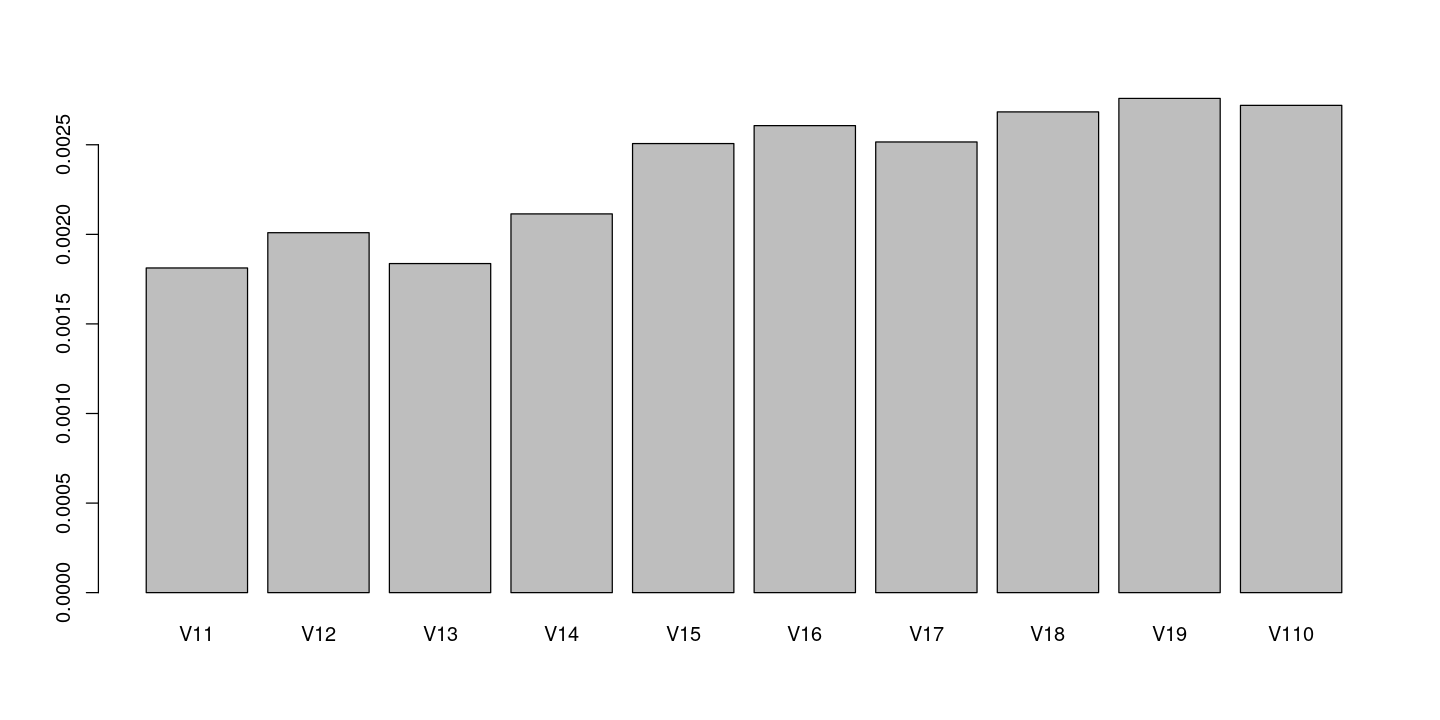

In [410]:
bins[,mean(vw),by=list(bin)] %>% arrange(bin) %>% dplyr::select(V1) %>% unlist %>% barplot

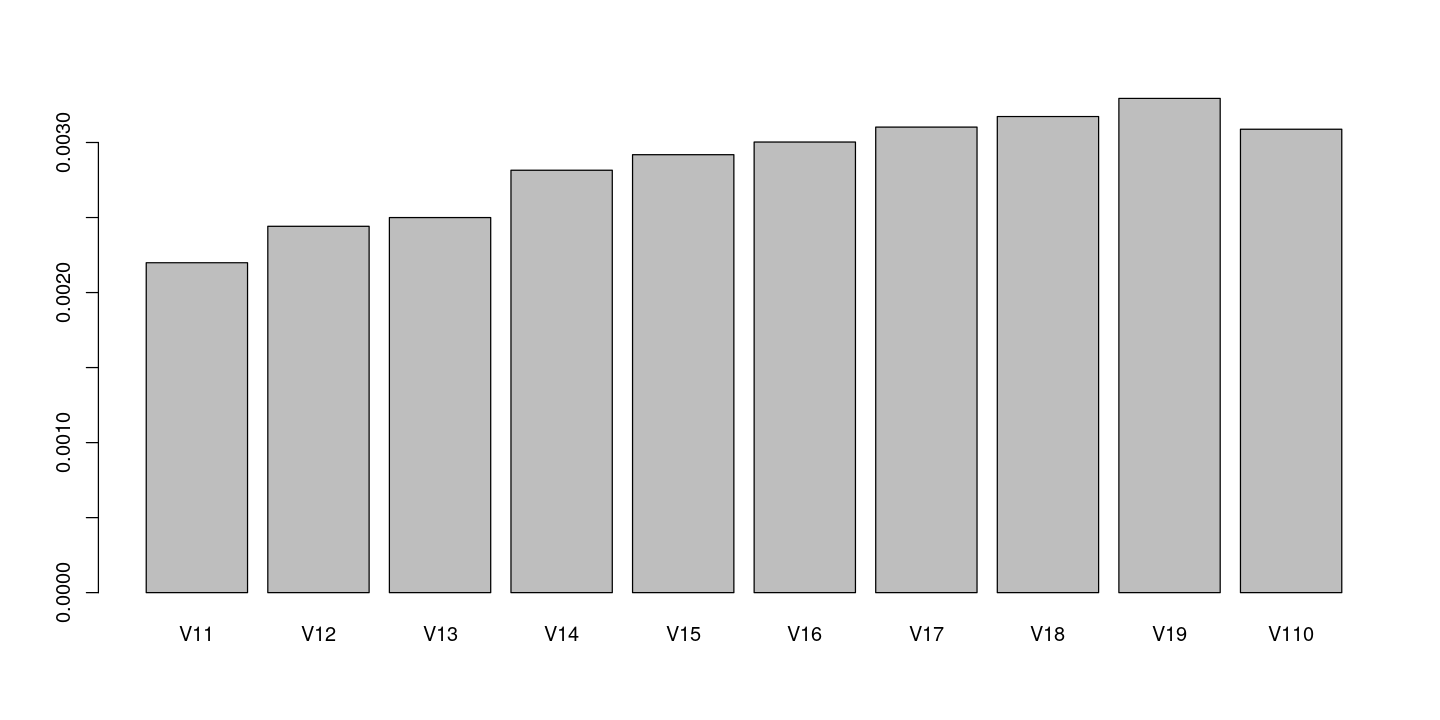

In [411]:
bins[,mean(ew),by=list(bin)] %>% arrange(bin) %>% dplyr::select(V1) %>% unlist %>% barplot

In [412]:
head(bins2)

ew,week_start,vw,vwcum,ewcum
<dbl>,<date>,<dbl>,<dbl>,<dbl>
-0.0531263767,1970-01-25,-0.051563804,0.9484362,0.9468736
0.0054548810,1970-02-01,-0.008150076,0.9407064,0.9520387
0.0094189099,1970-02-08,-0.019700423,0.9221741,0.9610059
0.0169773645,1970-02-15,0.001244964,0.9233221,0.9773212
0.0243558654,1970-02-22,0.016921956,0.9389465,1.0011247
0.0009663131,1970-03-01,0.001853351,0.9406867,1.0020921


In [413]:

eh=merge(weekly_factors,bins2,by=c('week_start')) 
list(feols(data=eh,ew ~ mkt_rf+smb+hml+rmw+cma+mom) ,
    feols(data=eh,vw ~ mkt_rf+smb+hml+rmw+cma+mom) ) %>% 
etable(se.below=TRUE)

,,model 1,model 2
,<chr>,<chr>,<chr>
1,Dependent Var.:,ew,vw
2,,,
3,Constant,0.0011***,0.0008**
4,,(0.0002),(0.0003)
5,mkt_rf,1.050***,1.016***
6,,(0.0112),(0.0137)
7,smb,0.7185***,0.0659**
8,,(0.0194),(0.0236)
9,hml,-0.1591***,-0.1680***
